In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to your files in Google Drive
folder_path = '/content/drive/My Drive/Capstone Data/'

# List all files in the folder
files = os.listdir(folder_path)
print(files)

['NOTEEVENTS.csv', 'ADMISSIONS.csv', 'PATIENTS.csv', 'DIAGNOSES_ICD.csv', 'ICUSTAYS.csv', 'PRESCRIPTIONS.csv', 'LABEVENTS.csv', 'PROCEDURES_ICD.csv', 'NoteSamples_By_Category.docx', 'CMS32_DESC_LONG_SHORT_DX.xlsx', 'clinical_note_embeddings.csv', 'final_note_embeddings.csv', 'mortality_catboost_model.pkl', 'readmission_catboost_model.pkl']


In [4]:
# List of file names
file_names = ['ADMISSIONS.csv', 'PATIENTS.csv', 'DIAGNOSES_ICD.csv', 'ICUSTAYS.csv', 'PRESCRIPTIONS.csv', 'PROCEDURES_ICD.csv', 'final_note_embeddings.csv']

# Load each file into a dictionary of DataFrames
dataframes = {}
for file in file_names:
    file_path = os.path.join(folder_path, file)
    dataframes[file] = pd.read_csv(file_path)

# Example: Access a specific DataFrame
Admissions_df = dataframes['ADMISSIONS.csv']
Patients_df = dataframes['PATIENTS.csv']
Diagnoses_df = dataframes['DIAGNOSES_ICD.csv']
Icustays_df = dataframes['ICUSTAYS.csv']
Prescriptions_df = dataframes['PRESCRIPTIONS.csv']
Procedures_df = dataframes['PROCEDURES_ICD.csv']
embeddings_df = dataframes['final_note_embeddings.csv']

<ipython-input-4-fda56241dd22>:8: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[file] = pd.read_csv(file_path)


<h2> Admission </h2>

<B>Identifying readmissions:</B> Calculating if a patient was readmitted within 30 days of discharge

Creating labels: Binary classification ('yes'/'no') for machine learning

Data preparation: Ensuring proper datetime formats and chronological ordering

<B>Key considerations:</B>

Patients may have multiple admissions

We only consider readmissions to the same hospital

Time between discharge and next admission must be ≤ 30 days

In [7]:
Admissions_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
6,27,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
7,28,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
8,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1
9,30,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,STATUS EPILEPTICUS,1,1


In [8]:
# Convert ADMITTIME and DISCHTIME to datetime
Admissions_df['ADMITTIME'] = pd.to_datetime(Admissions_df['ADMITTIME'])
Admissions_df['DISCHTIME'] = pd.to_datetime(Admissions_df['DISCHTIME'])

# Sort by SUBJECT_ID and ADMITTIME to align admissions chronologically per patient
Admissions_df = Admissions_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])

# Identify if there's a next admission for the same patient
Admissions_df['next_admittime'] = Admissions_df.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)

# Define the new target: future admission at any time
Admissions_df['future_admission'] = Admissions_df['next_admittime'].apply(
    lambda x: 'yes' if pd.notnull(x) else 'no'
)

# Optionally, check the class distribution
print(Admissions_df['future_admission'].value_counts())

# Drop the temporary column if no longer needed
Admissions_df.drop(columns=['next_admittime'], inplace=True)

future_admission
no     46520
yes    12456
Name: count, dtype: int64


In [9]:
 Admissions_df[['SUBJECT_ID', 'ADMITTIME', 'DISCHTIME', 'future_admission']].head(10)

,SUBJECT_ID,ADMITTIME,DISCHTIME,future_admission
211,2,2138-07-17 19:04:00,2138-07-21 15:48:00,no
212,3,2101-10-20 19:08:00,2101-10-31 13:58:00,no
213,4,2191-03-16 00:28:00,2191-03-23 18:41:00,no
214,5,2103-02-02 04:31:00,2103-02-04 12:15:00,no
215,6,2175-05-30 07:15:00,2175-06-15 16:00:00,no
216,7,2121-05-23 15:05:00,2121-05-27 11:57:00,no
217,8,2117-11-20 10:22:00,2117-11-24 14:20:00,no
218,9,2149-11-09 13:06:00,2149-11-14 10:15:00,no
219,10,2103-06-28 11:36:00,2103-07-06 12:10:00,no
220,11,2178-04-16 06:18:00,2178-05-11 19:00:00,no


In [10]:
Admissions_df.isna().sum()

,0
ROW_ID,0
SUBJECT_ID,0
HADM_ID,0
ADMITTIME,0
DISCHTIME,0
DEATHTIME,53122
ADMISSION_TYPE,0
ADMISSION_LOCATION,0
DISCHARGE_LOCATION,0
INSURANCE,0


<h2> Patients </h2>

In [11]:
nan_counts = Patients_df.isna().sum()
# Display the NaN counts for each column
print(nan_counts)

ROW_ID             0
SUBJECT_ID         0
GENDER             0
DOB                0
DOD            30761
DOD_HOSP       36546
DOD_SSN        33142
EXPIRE_FLAG        0
dtype: int64


In [12]:
Patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [13]:
Patients_df.head(10)

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
5,239,255,M,2109-08-05 00:00:00,NaN,NaN,NaN,0
6,240,256,M,2086-07-31 00:00:00,NaN,NaN,NaN,0
7,241,257,F,2031-04-03 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00,1
8,242,258,F,2124-09-19 00:00:00,NaN,NaN,NaN,0
9,243,260,F,2105-03-23 00:00:00,NaN,NaN,NaN,0


# Diagnoses

In [14]:
Diagnoses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [15]:
Diagnoses_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
5,1302,109,172335,6.0,2762
6,1303,109,172335,7.0,7100
7,1304,109,172335,8.0,2767
8,1305,109,172335,9.0,7243
9,1306,109,172335,10.0,45829


# Procedures

In [16]:
Procedures_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,331
5,949,55357,119355,3,3893
6,950,9545,158060,1,34
7,951,28600,189217,1,3613
8,952,28600,189217,2,3615
9,953,28600,189217,3,3961


In [17]:
Procedures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240095 entries, 0 to 240094
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   ROW_ID      240095 non-null  int64
 1   SUBJECT_ID  240095 non-null  int64
 2   HADM_ID     240095 non-null  int64
 3   SEQ_NUM     240095 non-null  int64
 4   ICD9_CODE   240095 non-null  int64
dtypes: int64(5)
memory usage: 9.2 MB


In [19]:
def add_clinical_codes(final_df, Diagnoses_df, Procedures_df):
    """
    Enhances dataset with aggregated clinical codes:
    1. Loads diagnoses/procedures data
    2. Aggregates codes by admission
    3. Merges with main dataset
    4. Returns enriched DataFrame
    """
    # Load and preprocess clinical data
    diagnoses = Diagnoses_df[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].drop_duplicates()
    procedures = Procedures_df[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].drop_duplicates()

    # Aggregate codes into lists per admission
    diag_agg = diagnoses.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()
    proc_agg = procedures.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()

    # Create copies to avoid SettingWithCopyWarning
    final_df = final_df.copy()

    # Merge with main dataset
    final_df = final_df.merge(
        diag_agg.rename(columns={'ICD9_CODE': 'DIAGNOSIS_CODES'}),
        on='HADM_ID',
        how='left'
    )
    final_df = final_df.merge(
        proc_agg.rename(columns={'ICD9_CODE': 'PROCEDURE_CODES'}),
        on='HADM_ID',
        how='left'
    )

    # Fill NaN values with empty lists
    final_df['DIAGNOSIS_CODES'] = final_df['DIAGNOSIS_CODES'].apply(lambda x: x if isinstance(x, list) else [])
    final_df['PROCEDURE_CODES'] = final_df['PROCEDURE_CODES'].apply(lambda x: x if isinstance(x, list) else [])

    return final_df

In [20]:
# Simply rename the input
final_df = add_clinical_codes(Admissions_df, Diagnoses_df, Procedures_df)

In [21]:
# Check the first few rows
print(final_df[['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS_CODES', 'PROCEDURE_CODES']].head(10))

   SUBJECT_ID  HADM_ID                                    DIAGNOSIS_CODES  \
0           2   163353                                [V3001, V053, V290]   
1           3   145834  [0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...   
2           4   185777  [042, 1363, 7994, 2763, 7907, 5715, 04111, V09...   
3           5   178980                                [V3000, V053, V290]   
4           6   107064  [40391, 4440, 9972, 2766, 2767, 2859, 2753, V1...   
5           7   118037                                [V3001, V053, V290]   
6           8   159514              [V3001, 7706, 7746, V290, V502, V053]   
7           9   150750                [431, 5070, 4280, 5849, 2765, 4019]   
8          10   184167                  [V3000, 7742, 76525, 76515, V290]   
9          11   194540                                             [1913]   

                       PROCEDURE_CODES  
0                               [9955]  
1  [9604, 9962, 8964, 9672, 3893, 966]  
2                   [3893, 88

In [22]:
def process_medications(prescriptions_df):
    """
    Processes prescription data:
    1. Groups medications by admission ID
    2. Aggregates drugs into lists per admission
    Returns: DataFrame with HADM_ID and aggregated medications
    """
    return prescriptions_df.groupby('HADM_ID')['DRUG'].apply(list).reset_index()

def merge_medications(final_df, medications_agg):
    """
    Merges medications with main dataset:
    1. Left joins medication lists
    2. Fills missing values with empty lists
    Returns: Enriched DataFrame
    """
    final_df = final_df.merge(medications_agg, on='HADM_ID', how='left')
    final_df['DRUG'] = final_df['DRUG'].apply(lambda x: x if isinstance(x, list) else [])
    return final_df

# Pipeline execution
medications_agg = process_medications(Prescriptions_df)
final_data = merge_medications(final_df, medications_agg)

# Verify merge
final_data[['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS_CODES', 'PROCEDURE_CODES', 'DRUG']].head(10)

,SUBJECT_ID,HADM_ID,DIAGNOSIS_CODES,PROCEDURE_CODES,DRUG
0,2,163353,"[V3001, V053, V290]",[9955],"[NEO*IV*Gentamicin, Syringe (Neonatal) *D5W*, ..."
1,3,145834,"[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...","[9604, 9962, 8964, 9672, 3893, 966]",[]
2,4,185777,"[042, 1363, 7994, 2763, 7907, 5715, 04111, V09...","[3893, 8872, 3323]","[Iso-Osmotic Dextrose, Insulin, Benzonatate, I..."
3,5,178980,"[V3000, V053, V290]",[9955],[]
4,6,107064,"[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1...","[5569, 91, 3957, 3806, 9904]","[Tacrolimus, Warfarin, Heparin Sodium, D5W, Fu..."
5,7,118037,"[V3001, V053, V290]",[9955],[]
6,8,159514,"[V3001, 7706, 7746, V290, V502, V053]","[9390, 640, 9955]","[Send 500mg Vial, NEO*IV*Gentamicin, NEO*IV*Am..."
7,9,150750,"[431, 5070, 4280, 5849, 2765, 4019]","[9672, 9604]","[SW, Labetalol HCl, Potassium Chloride, Potass..."
8,10,184167,"[V3000, 7742, 76525, 76515, V290]","[9983, 9915, 966]","[NEO*IV*Ampicillin Sodium, Send 500mg Vial, Sy..."
9,11,194540,[1913],"[159, 113, 9229, 9925]","[Tetanus-Diphtheria Toxoids-Td, Dexamethasone,..."


In [23]:
final_df.isnull().sum()

,0
ROW_ID,0
SUBJECT_ID,0
HADM_ID,0
ADMITTIME,0
DISCHTIME,0
DEATHTIME,53122
ADMISSION_TYPE,0
ADMISSION_LOCATION,0
DISCHARGE_LOCATION,0
INSURANCE,0


In [24]:
final_df.shape

(58976, 22)

In [25]:
final_df.columns.tolist()

['ROW_ID',
 'SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA',
 'future_admission',
 'DIAGNOSIS_CODES',
 'PROCEDURE_CODES']

In [26]:
def prepare_modeling_data(df):
    # Create a copy of the input DataFrame
    model_df = df.copy()

    # ======================================================
    # 1. Clean and Standardize Clinical Codes
    # ======================================================
    def clean_codes(x):
        """Convert codes to strings and handle missing values"""
        if isinstance(x, list):
            return [str(code).split('.')[0] for code in x]  # Remove decimals for consistency
        return []

    model_df['DIAGNOSIS_CODES'] = model_df['DIAGNOSIS_CODES'].apply(clean_codes)
    model_df['PROCEDURE_CODES'] = model_df['PROCEDURE_CODES'].apply(clean_codes)

    # ======================================================
    # 2. Feature Engineering
    # ======================================================
    # Length of Stay (LOS)
    model_df['LOS_DAYS'] = (pd.to_datetime(model_df['DISCHTIME']) -
                           pd.to_datetime(model_df['ADMITTIME'])).dt.total_seconds() / 86400

    # Clinical Flags (using first 3 digits)
    def has_code(codes, prefixes):
        """Check if any code starts with given prefixes"""
        if not isinstance(codes, list):
            return False
        return any(any(str(code).startswith(p) for p in prefixes) for code in codes)

    model_df['HAS_SEPSIS'] = model_df['DIAGNOSIS_CODES'].apply(
        lambda x: has_code(x, ['995']))
    model_df['HAS_DIABETES'] = model_df['DIAGNOSIS_CODES'].apply(
        lambda x: has_code(x, ['250']))
    model_df['HAS_VENT'] = model_df['PROCEDURE_CODES'].apply(
        lambda x: has_code(x, ['967', '9604']))

    # ======================================================
    # 3. Categorical Variable Processing
    # ======================================================
    # Simplify insurance categories
    insurance_map = {
        'Medicare': 'PUBLIC',
        'Medicaid': 'PUBLIC',
        'Government': 'PUBLIC',
        'Self Pay': 'PRIVATE',
        'Private': 'PRIVATE'
    }
    model_df['INSURANCE'] = model_df['INSURANCE'].replace(insurance_map).fillna('OTHER')

    # Simplify discharge locations
    discharge_map = {
        r'^HOME': 'HOME',
        r'DIED|HOSPICE|EXPIRED': 'DEATH',
        r'FACILITY|REHAB|SNF|ICF': 'FACILITY',
        r'.*': 'OTHER'
    }
    model_df['DISCHARGE_GROUP'] = (
        model_df['DISCHARGE_LOCATION']
        .str.upper()
        .replace(discharge_map, regex=True)
        .fillna('OTHER')
    )

    # ======================================================
    # 4. Safe One-Hot Encoding
    # ======================================================
    def safe_get_dummies(series, prefix):
        """Ensure dummy columns are created even if categories are missing"""
        dummies = pd.get_dummies(series, prefix=prefix)
        expected_cols = {
            'INSURANCE': ['INSURANCE_PUBLIC', 'INSURANCE_PRIVATE', 'INSURANCE_OTHER'],
            'DISCHARGE_GROUP': ['DISCHARGE_GROUP_HOME', 'DISCHARGE_GROUP_DEATH',
                               'DISCHARGE_GROUP_FACILITY', 'DISCHARGE_GROUP_OTHER']
        }
        for col in expected_cols.get(prefix, []):
            if col not in dummies.columns:
                dummies[col] = 0
        return dummies

    # Apply encoding
    insurance_dummies = safe_get_dummies(model_df['INSURANCE'], 'INSURANCE')
    discharge_dummies = safe_get_dummies(model_df['DISCHARGE_GROUP'], 'DISCHARGE_GROUP')

    # ======================================================
    # 5. Final Feature Selection
    # ======================================================
    # Base features
    base_features = [
        'HADM_ID',
        'LOS_DAYS',
        'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
        'ADMISSION_TYPE',
        'ADMISSION_LOCATION',
        'ETHNICITY',
        'DIAGNOSIS_CODES',  # Retained for feature engineering
        'PROCEDURE_CODES',  # Retained for feature engineering
        'HOSPITAL_EXPIRE_FLAG',
        'future_admission'
    ]

    # Combine all features
    final_df = pd.concat([
        model_df[base_features],
        insurance_dummies,
        discharge_dummies
    ], axis=1)

    # ======================================================
    # 6. Optional: Code-Based Feature Expansion
    # ======================================================
    # Add comorbidity counts if needed
    final_df['NUM_DIAGNOSES'] = final_df['DIAGNOSIS_CODES'].apply(len)
    final_df['NUM_PROCEDURES'] = final_df['PROCEDURE_CODES'].apply(len)

    return final_df

In [27]:
# Test on your data
model_df = prepare_modeling_data(final_df)
model_df.head(10)
# Validation checks
assert 'DIAGNOSIS_CODES' in model_df.columns, "Diagnosis codes missing!"
assert 'PROCEDURE_CODES' in model_df.columns, "Procedure codes missing!"
assert model_df['INSURANCE_PUBLIC'].isin([0,1]).all(), "Insurance encoding failed"
assert not model_df['DIAGNOSIS_CODES'].isnull().any(), "Nulls in diagnosis codes"

print("Final columns:", model_df.columns.tolist())

Final columns: ['HADM_ID', 'LOS_DAYS', 'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY', 'DIAGNOSIS_CODES', 'PROCEDURE_CODES', 'HOSPITAL_EXPIRE_FLAG', 'future_admission', 'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER', 'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME', 'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY', 'DISCHARGE_GROUP_OTHER', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']


# The Structured_df after Preprocessing and Feature Engineering

In [28]:
structured_df = model_df.copy(deep=True)

In [29]:
model_df.head(10)

,HADM_ID,LOS_DAYS,HAS_SEPSIS,HAS_DIABETES,HAS_VENT,ADMISSION_TYPE,ADMISSION_LOCATION,ETHNICITY,DIAGNOSIS_CODES,PROCEDURE_CODES,...,INSURANCE_PRIVATE,INSURANCE_PUBLIC,INSURANCE_OTHER,DISCHARGE_GROUP_OTHEROTHER,DISCHARGE_GROUP_HOME,DISCHARGE_GROUP_DEATH,DISCHARGE_GROUP_FACILITY,DISCHARGE_GROUP_OTHER,NUM_DIAGNOSES,NUM_PROCEDURES
0,163353,3.863889,False,False,False,NEWBORN,PHYS REFERRAL/NORMAL DELI,ASIAN,"[V3001, V053, V290]",[9955],...,True,False,0,True,0,0,0,0,3,1
1,145834,10.784722,False,False,True,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4...","[9604, 9962, 8964, 9672, 3893, 966]",...,False,True,0,True,0,0,0,0,9,6
2,185777,7.759028,False,False,False,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,"[042, 1363, 7994, 2763, 7907, 5715, 04111, V09...","[3893, 8872, 3323]",...,True,False,0,True,0,0,0,0,9,3
3,178980,2.322222,False,False,False,NEWBORN,PHYS REFERRAL/NORMAL DELI,ASIAN,"[V3000, V053, V290]",[9955],...,True,False,0,True,0,0,0,0,3,1
4,107064,16.364583,False,False,False,ELECTIVE,PHYS REFERRAL/NORMAL DELI,WHITE,"[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1...","[5569, 91, 3957, 3806, 9904]",...,False,True,0,True,0,0,0,0,8,5
5,118037,3.869444,False,False,False,NEWBORN,PHYS REFERRAL/NORMAL DELI,WHITE,"[V3001, V053, V290]",[9955],...,True,False,0,True,0,0,0,0,3,1
6,159514,4.165278,False,False,False,NEWBORN,PHYS REFERRAL/NORMAL DELI,WHITE,"[V3001, 7706, 7746, V290, V502, V053]","[9390, 640, 9955]",...,True,False,0,True,0,0,0,0,6,3
7,150750,4.881250,False,False,True,EMERGENCY,EMERGENCY ROOM ADMIT,UNKNOWN/NOT SPECIFIED,"[431, 5070, 4280, 5849, 2765, 4019]","[9672, 9604]",...,False,True,0,True,0,0,0,0,6,2
8,184167,8.023611,False,False,False,NEWBORN,PHYS REFERRAL/NORMAL DELI,BLACK/AFRICAN AMERICAN,"[V3000, 7742, 76525, 76515, V290]","[9983, 9915, 966]",...,False,True,0,True,0,0,0,0,5,3
9,194540,25.529167,False,False,False,EMERGENCY,EMERGENCY ROOM ADMIT,WHITE,[1913],"[159, 113, 9229, 9925]",...,True,False,0,True,0,0,0,0,1,4


In [29]:
# Check missing values per column
missing_values = model_df.isnull().sum()
print(missing_values)

HADM_ID                       0
LOS_DAYS                      0
HAS_SEPSIS                    0
HAS_DIABETES                  0
HAS_VENT                      0
ADMISSION_TYPE                0
ADMISSION_LOCATION            0
ETHNICITY                     0
DIAGNOSIS_CODES               0
PROCEDURE_CODES               0
HOSPITAL_EXPIRE_FLAG          0
future_admission              0
INSURANCE_PRIVATE             0
INSURANCE_PUBLIC              0
INSURANCE_OTHER               0
DISCHARGE_GROUP_OTHEROTHER    0
DISCHARGE_GROUP_HOME          0
DISCHARGE_GROUP_DEATH         0
DISCHARGE_GROUP_FACILITY      0
DISCHARGE_GROUP_OTHER         0
NUM_DIAGNOSES                 0
NUM_PROCEDURES                0
dtype: int64


In [ ]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   HADM_ID                     58976 non-null  int64  
 1   LOS_DAYS                    58976 non-null  float64
 2   HAS_SEPSIS                  58976 non-null  bool   
 3   HAS_DIABETES                58976 non-null  bool   
 4   HAS_VENT                    58976 non-null  bool   
 5   ADMISSION_TYPE              58976 non-null  object 
 6   ADMISSION_LOCATION          58976 non-null  object 
 7   ETHNICITY                   58976 non-null  object 
 8   DIAGNOSIS_CODES             58976 non-null  object 
 9   PROCEDURE_CODES             58976 non-null  object 
 10  HOSPITAL_EXPIRE_FLAG        58976 non-null  int64  
 11  future_admission            58976 non-null  object 
 12  INSURANCE_PRIVATE           58976 non-null  bool   
 13  INSURANCE_PUBLIC            589

<h2> Data Visualizations

<h2> Correlation  Heatmap

In [ ]:
# 1. Select relevant features
corr_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES',
                 'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT', 'HOSPITAL_EXPIRE_FLAG']

# 2. Correlation
corr_matrix = model_df[corr_features].corr()

# 3. Interactive plot
fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title='Interactive Correlation Heatmap'
)
fig.update_layout(
    width=800,
    height=700,
    xaxis_title="Features",
    yaxis_title="Features",
    coloraxis_colorbar=dict(title="Correlation")
)
fig.show()


#Future Admission

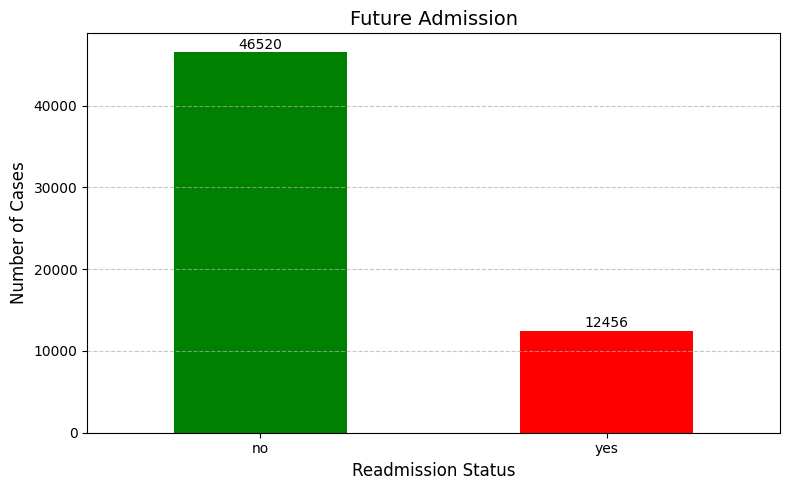

In [ ]:
# Count the number of YES/NO readmissions
readmission_counts = Admissions_df['future_admission'].value_counts()

# Create a simple bar plot
plt.figure(figsize=(8, 5))
readmission_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Future Admission', fontsize=14)
plt.xlabel('Readmission Status', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(readmission_counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

This bar chart displays patient readmission status. Out of the total cases, 12,456 patients were readmitted, while 46,520 had no future admissions. This indicates a readmission rate of approximately 21%, highlighting the need to monitor factors contributing to patient returns.

#Comorbidity Proportion

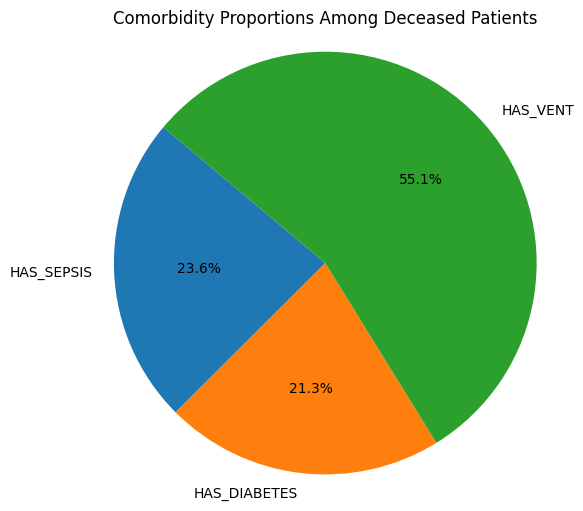

In [ ]:
import matplotlib.pyplot as plt

# Filter only deceased patients
deceased = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 1]

# Calculate comorbidity rates among deceased
comorbidities_dead = deceased[['HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT']].mean()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(comorbidities_dead, labels=comorbidities_dead.index, autopct='%1.1f%%', startangle=140)
plt.title("Comorbidity Proportions Among Deceased Patients")
plt.axis('equal')
plt.show()


Among the patients who died during hospitalization, ventilator use emerged as the most prevalent comorbidity, present in approximately 55.1% of cases. This was followed by sepsis, which affected 23.6% of the deceased patients, and diabetes, which was observed in 21.3%. These proportions suggest that the need for mechanical ventilation is strongly associated with fatal outcomes, potentially indicating the severity of clinical deterioration. The notable presence of sepsis and diabetes further reinforces their role as critical risk factors contributing to increased mortality in hospitalized patients.

#Mortality Rate by Procedure Group and Insurance Type

In [ ]:
bins = [0, 2, 5, 10, 100]
labels = ['0-2', '3-5', '6-10', '10+'] # Here the range is mentioning the severness
model_df['Procedure_Group'] = pd.cut(model_df['NUM_PROCEDURES'], bins=bins, labels=labels)
insurance_map = {
    'INSURANCE_PRIVATE': 'Private',
    'INSURANCE_PUBLIC': 'Public',
    'INSURANCE_OTHER': 'Other'
}
ins_cols = list(insurance_map.keys())

melted = model_df.melt(id_vars=['Procedure_Group', 'HOSPITAL_EXPIRE_FLAG'], value_vars=ins_cols)
melted = melted[melted['value'] == 1]
melted['Insurance_Type'] = melted['variable'].map(insurance_map)
mortality = melted.groupby(['Procedure_Group', 'Insurance_Type'])['HOSPITAL_EXPIRE_FLAG'].mean().reset_index()
mortality.columns = ['Procedure_Group', 'Insurance_Type', 'Mortality Rate']
fig = px.bar(mortality, x='Procedure_Group', y='Mortality Rate', color='Insurance_Type', barmode='group',
             title='Mortality Rate by Procedure Group and Insurance Type')
fig.show()


<ipython-input-37-5ab176a20375>:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



The chart shows that mortality increases with the number of procedures for both insurance types. However, publicly insured patients consistently have higher mortality rates across all procedure groups, suggesting possible disparities in outcomes related to insurance coverage and patient severity.

#LOS and Number of Diagnoses across Admission Types

In [ ]:
# 1. Group by Admission Type
admission_summary = model_df.groupby('ADMISSION_TYPE').agg(
    avg_los=('LOS_DAYS', 'mean'),
    avg_num_diagnoses=('NUM_DIAGNOSES', 'mean')
).reset_index()

# 2. Create figure
fig = go.Figure()

# Add bar for LOS
fig.add_trace(go.Bar(
    x=admission_summary['ADMISSION_TYPE'],
    y=admission_summary['avg_los'],
    name='Average LOS',
    yaxis='y1'
))

# Add line for Number of Diagnoses
fig.add_trace(go.Scatter(
    x=admission_summary['ADMISSION_TYPE'],
    y=admission_summary['avg_num_diagnoses'],
    name='Average Number of Diagnoses',
    yaxis='y2',
    mode='lines+markers',
    line=dict(color='firebrick', width=4)
))

# 3. Layout with two Y-axes
fig.update_layout(
    title="LOS and Number of Diagnoses across Admission Types",
    xaxis=dict(title="Admission Type"),
    yaxis=dict(title="Average LOS (Days)", side='left'),
    yaxis2=dict(title="Average Number of Diagnoses", overlaying='y', side='right'),
    legend=dict(x=0.8, y=1.2),
    bargap=0.4
)

fig.show()


This chart compares the average length of stay (LOS) and number of diagnoses across different admission types. URGENT admissions show the highest LOS and diagnostic count, indicating prolonged hospital care for complex but non-immediate conditions. In contrast, EMERGENCY admissions involve life-threatening cases requiring immediate intervention, reflected by a slightly lower LOS despite a high number of diagnoses. The distinction highlights that emergency admissions are driven by critical instability, whereas urgent admissions involve serious but not immediately fatal conditions, often requiring extended evaluation and treatment.

#Average Length of Stay by Admission Location

In [ ]:
avg_los_by_loc = model_df.groupby('ADMISSION_LOCATION')['LOS_DAYS'].mean().reset_index().sort_values(by='LOS_DAYS')

fig = px.bar(avg_los_by_loc,
             x='ADMISSION_LOCATION',
             y='LOS_DAYS',
             title='Average LOS by Admission Location')

# Rotate x-axis labels
fig.update_layout(xaxis_tickangle=-45)
fig.show()


This chart shows the average length of stay (LOS) across different admission locations. Patients transferred from other healthcare facilities had the longest stays, averaging over 21 days, indicating higher complexity or critical conditions. In contrast, admissions from within the same facility had the shortest stays, suggesting less severe or well-managed cases.

<h1> Data Modelling

<h1> XGBOOST

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[01:17:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Best Parameters for Mortality Model: {'classifier__subsample': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

Mortality Model Performance
AUC: 0.872
MCC: 0.409
Sensitivity (Recall for deaths): 0.260
Specificity (for survivors): 0.990

Confusion Matrix:
 [[10520   105]
 [  866   305]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     10625
           1       0.74      0.26      0.39      1171

    accuracy                           0.92     11796
   macro avg       0.83      0.63      0.67     11796
weighted avg       0.91      0.92      0.90     11796



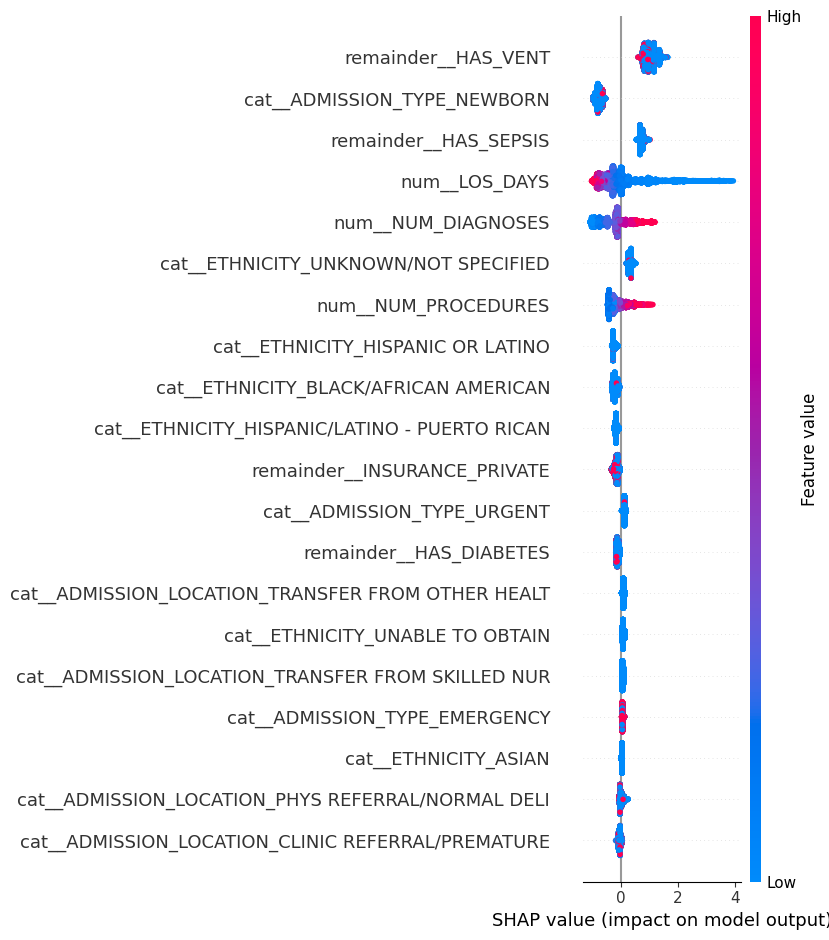

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[01:17:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Best Parameters for Readmission Model: {'classifier__subsample': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

Readmission Model Performance
AUC: 0.714
MCC: 0.121
Sensitivity (Recall for readmissions): 0.054
Specificity (for survivors): 0.988

Confusion Matrix:
 [[8045   98]
 [2348  134]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.99      0.87      8143
           1       0.58      0.05      0.10      2482

    accuracy                           0.77     10625
   macro avg       0.68      0.52      0.48     10625
weighted avg       0.73      0.77      0.69     10625



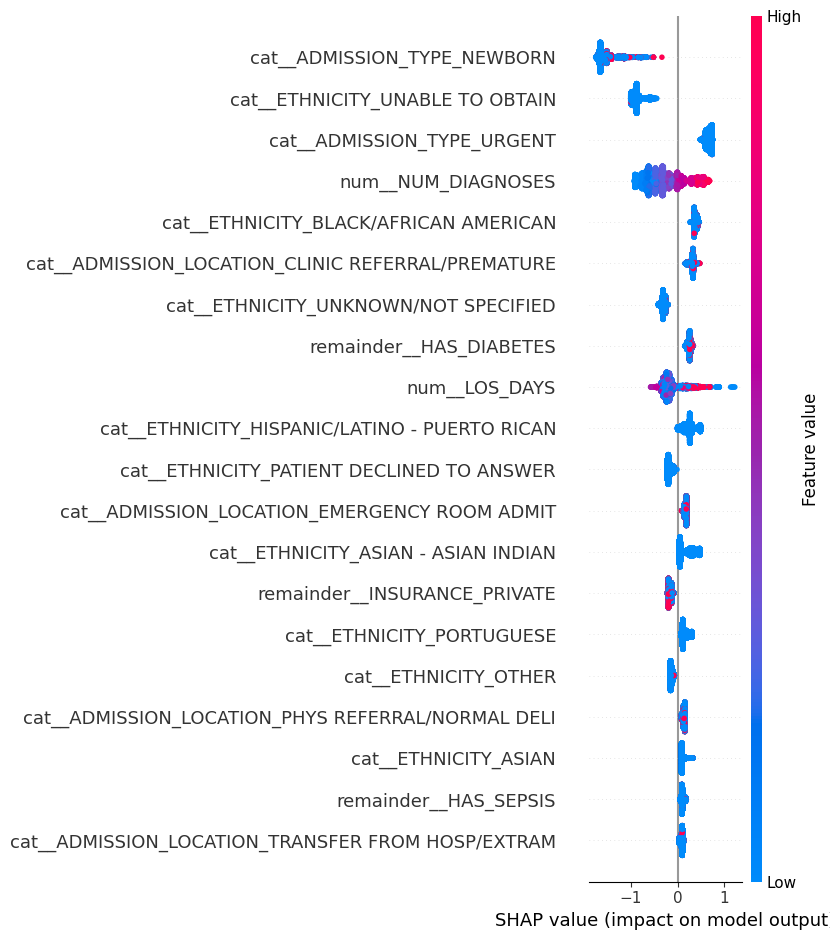

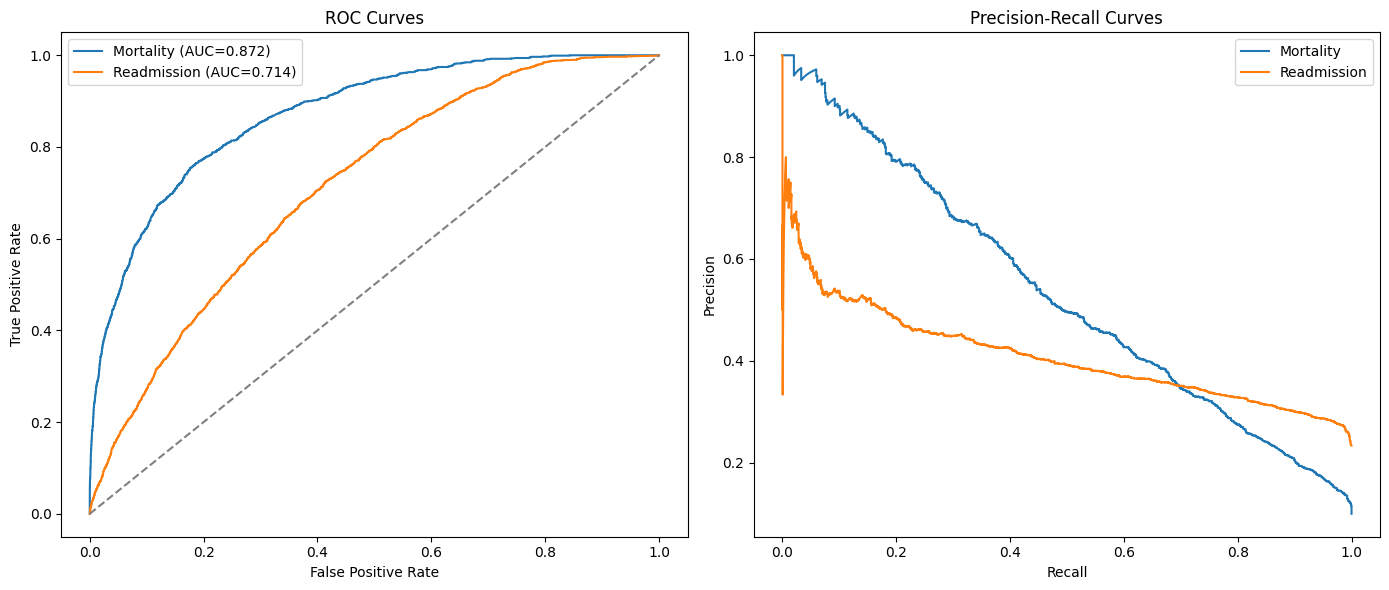

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_curve, precision_recall_curve
)

# ------------------- FEATURE SETUP -------------------
numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']
binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']
features = numeric_features + binary_features + categorical_features

# ------------------- PREPROCESSOR -------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

# ------------------- HYPERPARAMETER GRID -------------------
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.9, 1.0]
}

# ------------------- MORTALITY PREDICTION -------------------
X_mort = model_df[features]
y_mort = model_df['HOSPITAL_EXPIRE_FLAG']

X_train_mort, X_test_mort, y_train_mort, y_test_mort = train_test_split(
    X_mort, y_mort, test_size=0.2, stratify=y_mort, random_state=42
)

mort_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

mort_search = RandomizedSearchCV(
    mort_pipeline, param_distributions=param_grid, n_iter=10,
    cv=5, scoring='roc_auc', random_state=42, n_jobs=-1
)
mort_search.fit(X_train_mort, y_train_mort)

best_mort_pipeline = mort_search.best_estimator_

print("\nBest Parameters for Mortality Model:", mort_search.best_params_)

# Predictions
y_pred_probs_mort = best_mort_pipeline.predict_proba(X_test_mort)[:, 1]
y_pred_mort = (y_pred_probs_mort > 0.5).astype(int)

# Metrics
print("\nMortality Model Performance")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_mort, y_pred_probs_mort):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_mort, y_pred_mort):.3f}")

conf_mort = confusion_matrix(y_test_mort, y_pred_mort)
TN, FP, FN, TP = conf_mort.ravel()
sensitivity_mort = TP / (TP + FN)
specificity_mort = TN / (TN + FP)

print(f"Sensitivity (Recall for deaths): {sensitivity_mort:.3f}")
print(f"Specificity (for survivors): {specificity_mort:.3f}")
print("\nConfusion Matrix:\n", conf_mort)
print("\nClassification Report:\n", classification_report(y_test_mort, y_pred_mort))

# SHAP Analysis for Mortality
fitted_preprocessor_mort = best_mort_pipeline.named_steps['preprocessor']
X_test_transformed_mort = fitted_preprocessor_mort.transform(X_test_mort)
if hasattr(X_test_transformed_mort, 'toarray'):
    X_test_transformed_mort = X_test_transformed_mort.toarray()

explainer_mort = shap.Explainer(best_mort_pipeline.named_steps['classifier'])
shap_values_mort = explainer_mort(X_test_transformed_mort)
shap.summary_plot(shap_values_mort, X_test_transformed_mort, feature_names=fitted_preprocessor_mort.get_feature_names_out())

# ------------------- READMISSION PREDICTION -------------------
readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
X_readmit = readmit_df[features]
y_readmit = readmit_df['future_admission'].map({'yes': 1, 'no': 0})

X_train_readmit, X_test_readmit, y_train_readmit, y_test_readmit = train_test_split(
    X_readmit, y_readmit, test_size=0.2, stratify=y_readmit, random_state=42
)

readmit_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

readmit_search = RandomizedSearchCV(
    readmit_pipeline, param_distributions=param_grid, n_iter=10,
    cv=5, scoring='roc_auc', random_state=42, n_jobs=-1
)
readmit_search.fit(X_train_readmit, y_train_readmit)

best_readmit_pipeline = readmit_search.best_estimator_

print("\nBest Parameters for Readmission Model:", readmit_search.best_params_)

# Predictions
y_pred_probs_readmit = best_readmit_pipeline.predict_proba(X_test_readmit)[:, 1]
y_pred_readmit = (y_pred_probs_readmit > 0.5).astype(int)

# Metrics
print("\nReadmission Model Performance")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_readmit, y_pred_probs_readmit):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_readmit, y_pred_readmit):.3f}")

conf_readmit = confusion_matrix(y_test_readmit, y_pred_readmit)
TN_r, FP_r, FN_r, TP_r = conf_readmit.ravel()
sensitivity_readmit = TP_r / (TP_r + FN_r)
specificity_readmit = TN_r / (TN_r + FP_r)

print(f"Sensitivity (Recall for readmissions): {sensitivity_readmit:.3f}")
print(f"Specificity (for survivors): {specificity_readmit:.3f}")
print("\nConfusion Matrix:\n", conf_readmit)
print("\nClassification Report:\n", classification_report(y_test_readmit, y_pred_readmit))

# SHAP Analysis for Readmission
fitted_preprocessor_readmit = best_readmit_pipeline.named_steps['preprocessor']
X_test_transformed_readmit = fitted_preprocessor_readmit.transform(X_test_readmit)
if hasattr(X_test_transformed_readmit, 'toarray'):
    X_test_transformed_readmit = X_test_transformed_readmit.toarray()

explainer_readmit = shap.Explainer(best_readmit_pipeline.named_steps['classifier'])
shap_values_readmit = explainer_readmit(X_test_transformed_readmit)
shap.summary_plot(shap_values_readmit, X_test_transformed_readmit, feature_names=fitted_preprocessor_readmit.get_feature_names_out())

# ------------------- PLOTTING ROC and PR CURVES -------------------
def plot_all_curves(y_true1, probs1, label1, y_true2, probs2, label2):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curves
    fpr1, tpr1, _ = roc_curve(y_true1, probs1)
    fpr2, tpr2, _ = roc_curve(y_true2, probs2)
    axs[0].plot(fpr1, tpr1, label=f'{label1} (AUC={roc_auc_score(y_true1, probs1):.3f})')
    axs[0].plot(fpr2, tpr2, label=f'{label2} (AUC={roc_auc_score(y_true2, probs2):.3f})')
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0].set_title('ROC Curves')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()

    # Precision-Recall Curves
    prec1, rec1, _ = precision_recall_curve(y_true1, probs1)
    prec2, rec2, _ = precision_recall_curve(y_true2, probs2)
    axs[1].plot(rec1, prec1, label=f'{label1}')
    axs[1].plot(rec2, prec2, label=f'{label2}')
    axs[1].set_title('Precision-Recall Curves')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_all_curves(
    y_test_mort, y_pred_probs_mort, 'Mortality',
    y_test_readmit, y_pred_probs_readmit, 'Readmission'
)


<h2> CatBoost


Best Params (Mortality): {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 6}

Mortality Prediction
AUC: 0.876
MCC: 0.421
Sensitivity (Recall for deaths): 0.278
Specificity (for survivors): 0.989

Confusion Matrix:
 [[10508   117]
 [  845   326]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96     10625
           1       0.74      0.28      0.40      1171

    accuracy                           0.92     11796
   macro avg       0.83      0.63      0.68     11796
weighted avg       0.91      0.92      0.90     11796



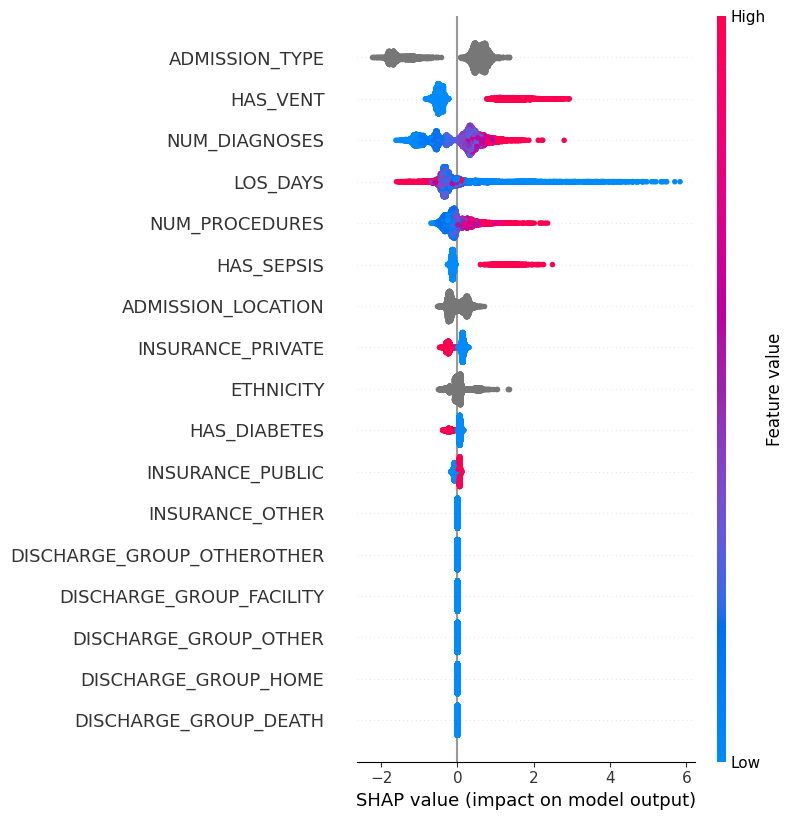


Best Params (Readmission): {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 6}

Readmission Prediction
AUC: 0.716
MCC: 0.143
Sensitivity (Recall for readmissions): 0.082
Specificity (for survivors): 0.980

Confusion Matrix:
 [[7978  165]
 [2278  204]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87      8143
           1       0.55      0.08      0.14      2482

    accuracy                           0.77     10625
   macro avg       0.67      0.53      0.51     10625
weighted avg       0.73      0.77      0.70     10625



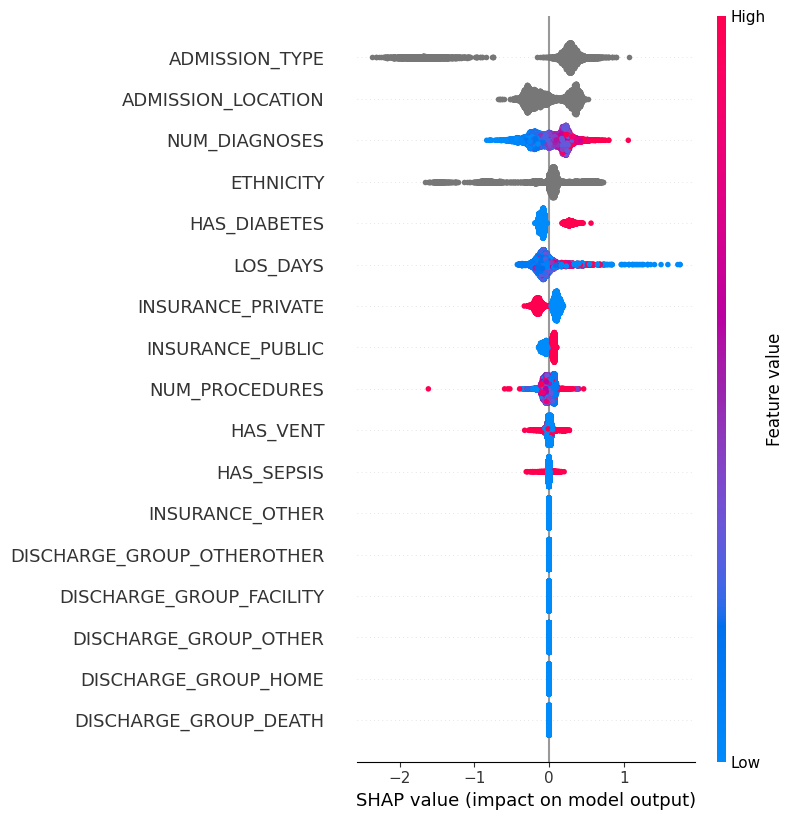

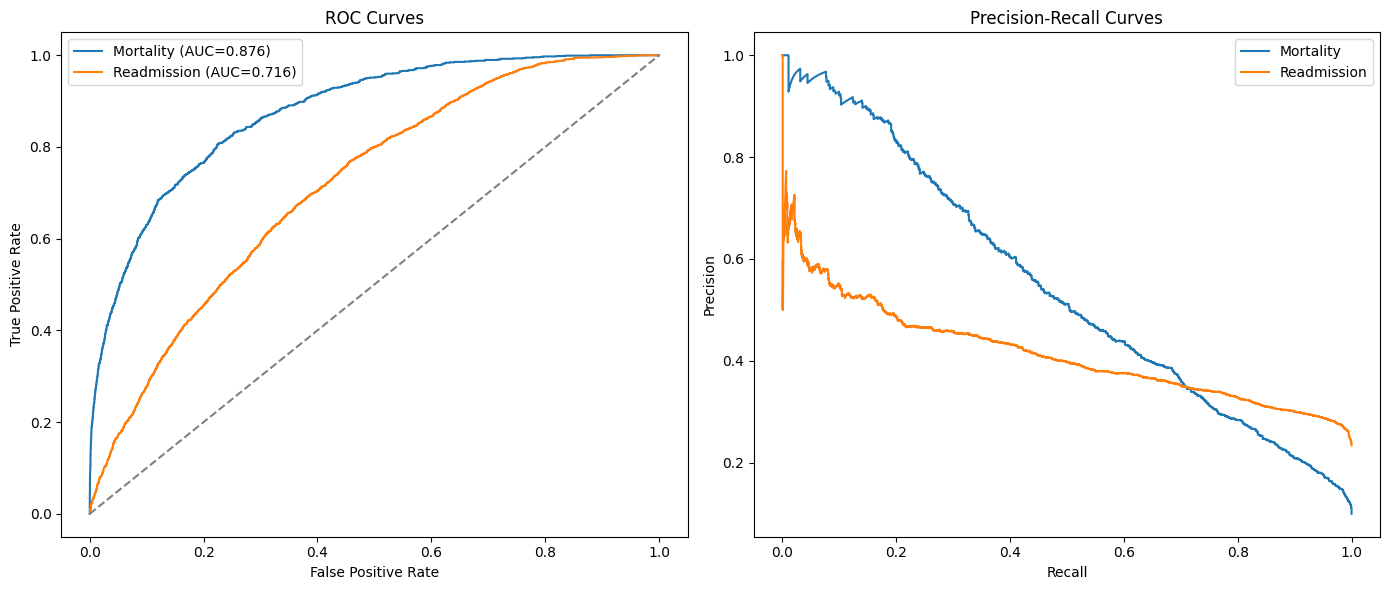

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_curve, precision_recall_curve,
    precision_score, recall_score, accuracy_score
)
from catboost import CatBoostClassifier

# ------------------- FEATURE SETUP -------------------
numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']
binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']
features = numeric_features + binary_features + categorical_features

# ------------------- TRAIN/TEST SPLITS -------------------
# Mortality data
X_mort = model_df[features]
y_mort = model_df['HOSPITAL_EXPIRE_FLAG']
X_train_mort, X_test_mort, y_train_mort, y_test_mort = train_test_split(
    X_mort, y_mort, test_size=0.2, stratify=y_mort, random_state=42
)

# Readmission data (only survivors)
readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
X_readmit = readmit_df[features]
y_readmit = readmit_df['future_admission'].map({'yes': 1, 'no': 0})
X_train_readmit, X_test_readmit, y_train_readmit, y_test_readmit = train_test_split(
    X_readmit, y_readmit, test_size=0.2, stratify=y_readmit, random_state=42
)

# ------------------- HYPERPARAMETER GRID -------------------
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# ------------------- MORTALITY MODEL -------------------
cat_mort = CatBoostClassifier(verbose=0, cat_features=categorical_features)
search_mort = RandomizedSearchCV(cat_mort, param_distributions=param_grid, n_iter=10,
                                 scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
search_mort.fit(X_train_mort, y_train_mort)
best_mort = search_mort.best_estimator_
y_pred_probs_mort = best_mort.predict_proba(X_test_mort)[:, 1]
y_pred_mort = (y_pred_probs_mort > 0.5).astype(int)

print("\nBest Params (Mortality):", search_mort.best_params_)
print("\nMortality Prediction")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_mort, y_pred_probs_mort):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_mort, y_pred_mort):.3f}")

# Confusion matrix & Sensitivity/Specificity
conf_mort = confusion_matrix(y_test_mort, y_pred_mort)
TN, FP, FN, TP = conf_mort.ravel()
sensitivity_mort = TP / (TP + FN)
specificity_mort = TN / (TN + FP)

print(f"Sensitivity (Recall for deaths): {sensitivity_mort:.3f}")
print(f"Specificity (for survivors): {specificity_mort:.3f}")
print("\nConfusion Matrix:\n", conf_mort)
print("\nClassification Report:\n", classification_report(y_test_mort, y_pred_mort))

# SHAP for Mortality
explainer_mort = shap.TreeExplainer(best_mort)
shap_values_mort = explainer_mort.shap_values(X_test_mort)
shap.summary_plot(shap_values_mort, X_test_mort, feature_names=features)

# ------------------- READMISSION MODEL -------------------
cat_readmit = CatBoostClassifier(verbose=0, cat_features=categorical_features)
search_readmit = RandomizedSearchCV(cat_readmit, param_distributions=param_grid, n_iter=10,
                                    scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
search_readmit.fit(X_train_readmit, y_train_readmit)
best_readmit = search_readmit.best_estimator_
y_pred_probs_readmit = best_readmit.predict_proba(X_test_readmit)[:, 1]
y_pred_readmit = (y_pred_probs_readmit > 0.5).astype(int)

print("\nBest Params (Readmission):", search_readmit.best_params_)
print("\nReadmission Prediction")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_readmit, y_pred_probs_readmit):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_readmit, y_pred_readmit):.3f}")

# Confusion matrix & Sensitivity/Specificity
conf_readmit = confusion_matrix(y_test_readmit, y_pred_readmit)
TN_r, FP_r, FN_r, TP_r = conf_readmit.ravel()
sensitivity_readmit = TP_r / (TP_r + FN_r)
specificity_readmit = TN_r / (TN_r + FP_r)

print(f"Sensitivity (Recall for readmissions): {sensitivity_readmit:.3f}")
print(f"Specificity (for survivors): {specificity_readmit:.3f}")
print("\nConfusion Matrix:\n", conf_readmit)
print("\nClassification Report:\n", classification_report(y_test_readmit, y_pred_readmit))

# SHAP for Readmission
explainer_readmit = shap.TreeExplainer(best_readmit)
shap_values_readmit = explainer_readmit.shap_values(X_test_readmit)
shap.summary_plot(shap_values_readmit, X_test_readmit, feature_names=features)

# ------------------- PLOTTING -------------------
def plot_all_curves(y_true1, probs1, label1, y_true2, probs2, label2):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curves
    fpr1, tpr1, _ = roc_curve(y_true1, probs1)
    fpr2, tpr2, _ = roc_curve(y_true2, probs2)
    axs[0].plot(fpr1, tpr1, label=f'{label1} (AUC={roc_auc_score(y_true1, probs1):.3f})')
    axs[0].plot(fpr2, tpr2, label=f'{label2} (AUC={roc_auc_score(y_true2, probs2):.3f})')
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0].set_title('ROC Curves')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()

    # Precision-Recall Curves
    prec1, rec1, _ = precision_recall_curve(y_true1, probs1)
    prec2, rec2, _ = precision_recall_curve(y_true2, probs2)
    axs[1].plot(rec1, prec1, label=f'{label1}')
    axs[1].plot(rec2, prec2, label=f'{label2}')
    axs[1].set_title('Precision-Recall Curves')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_all_curves(
    y_test_mort, y_pred_probs_mort, 'Mortality',
    y_test_readmit, y_pred_probs_readmit, 'Readmission'
)


#Desicion Tree

Best Params (Mortality - Decision Tree): {'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy'}

Mortality Prediction (Decision Tree)
AUC: 0.848
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     10625
           1       0.27      0.79      0.40      1171

    accuracy                           0.77     11796
   macro avg       0.62      0.78      0.63     11796
weighted avg       0.90      0.77      0.81     11796


Best Params (Readmission - Decision Tree): {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy'}

Readmission Prediction (Decision Tree)
AUC: 0.692
              precision    recall  f1-score   support

           0       0.87      0.55      0.67      8143
           1       0.33      0.72      0.45      2482

    accuracy                           0.59     10

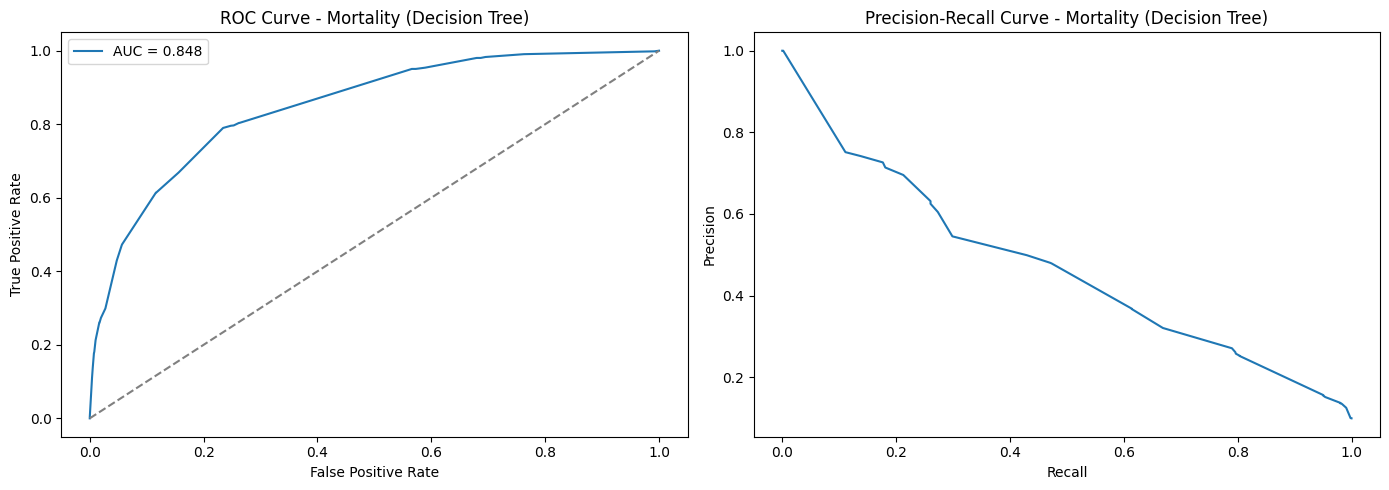

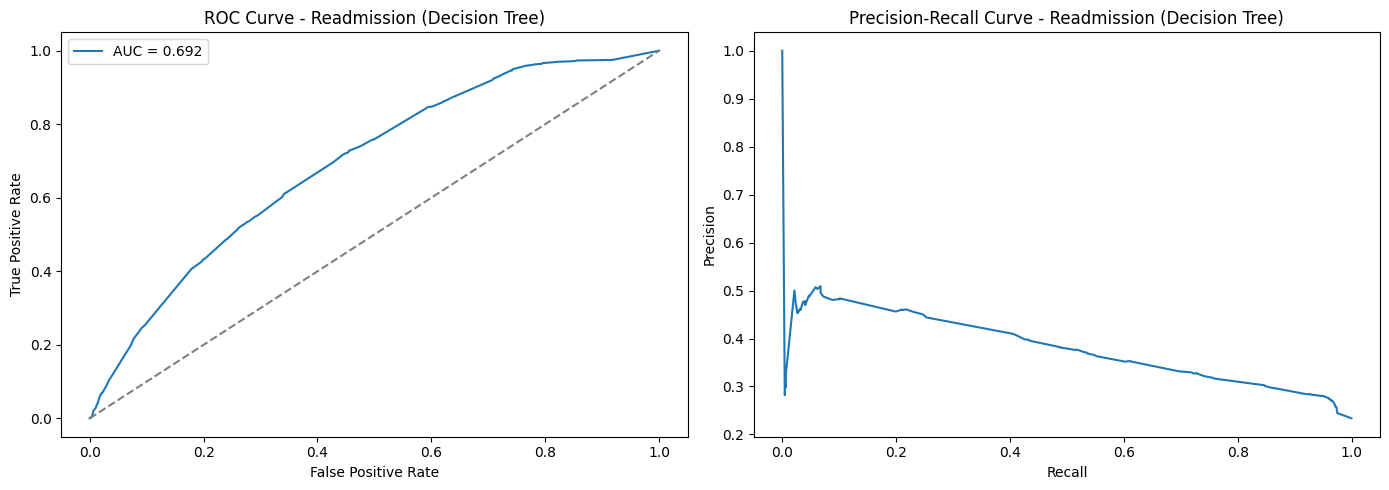

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------- FEATURES -------------------
numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']
binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']
features = numeric_features + binary_features + categorical_features

# ------------------- PREPROCESSING -------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# ------------------- HYPERPARAMETER GRID -------------------
param_grid = {
    'classifier__max_depth': [3, 5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

# ------------------- MORTALITY MODEL -------------------
X_mort = model_df[features]
y_mort = model_df['HOSPITAL_EXPIRE_FLAG']
X_train_mort, X_test_mort, y_train_mort, y_test_mort = train_test_split(
    X_mort, y_mort, test_size=0.2, stratify=y_mort, random_state=42
)

pipeline_mort = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

search_mort = RandomizedSearchCV(pipeline_mort, param_distributions=param_grid, n_iter=10,
                                  scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
search_mort.fit(X_train_mort, y_train_mort)
best_dt_mort = search_mort.best_estimator_
y_pred_probs_mort = best_dt_mort.predict_proba(X_test_mort)[:, 1]

print("Best Params (Mortality - Decision Tree):", search_mort.best_params_)
print("\nMortality Prediction (Decision Tree)")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_mort, y_pred_probs_mort):.3f}")
print(classification_report(y_test_mort, y_pred_probs_mort > 0.5))

# ------------------- READMISSION MODEL -------------------
readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
X_readmit = readmit_df[features]
y_readmit = readmit_df['future_admission'].map({'yes': 1, 'no': 0})
X_train_readmit, X_test_readmit, y_train_readmit, y_test_readmit = train_test_split(
    X_readmit, y_readmit, test_size=0.2, stratify=y_readmit, random_state=42
)

pipeline_readmit = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

search_readmit = RandomizedSearchCV(pipeline_readmit, param_distributions=param_grid, n_iter=10,
                                     scoring='roc_auc', cv=5, random_state=42, n_jobs=-1)
search_readmit.fit(X_train_readmit, y_train_readmit)
best_dt_readmit = search_readmit.best_estimator_
y_pred_probs_readmit = best_dt_readmit.predict_proba(X_test_readmit)[:, 1]

print("\nBest Params (Readmission - Decision Tree):", search_readmit.best_params_)
print("\nReadmission Prediction (Decision Tree)")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_readmit, y_pred_probs_readmit):.3f}")
print(classification_report(y_test_readmit, y_pred_probs_readmit > 0.5))

# ------------------- PLOTTING -------------------
def plot_curves(y_true, probs, label):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    fpr, tpr, _ = roc_curve(y_true, probs)
    axs[0].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, probs):.3f}")
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0].set_title(f'ROC Curve - {label}')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()

    prec, rec, _ = precision_recall_curve(y_true, probs)
    axs[1].plot(rec, prec, label='PR Curve')
    axs[1].set_title(f'Precision-Recall Curve - {label}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')

    plt.tight_layout()
    plt.show()

plot_curves(y_test_mort, y_pred_probs_mort, "Mortality (Decision Tree)")
plot_curves(y_test_readmit, y_pred_probs_readmit, "Readmission (Decision Tree)")


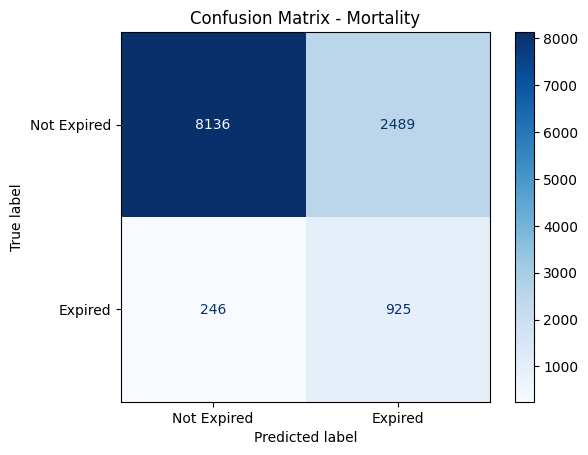

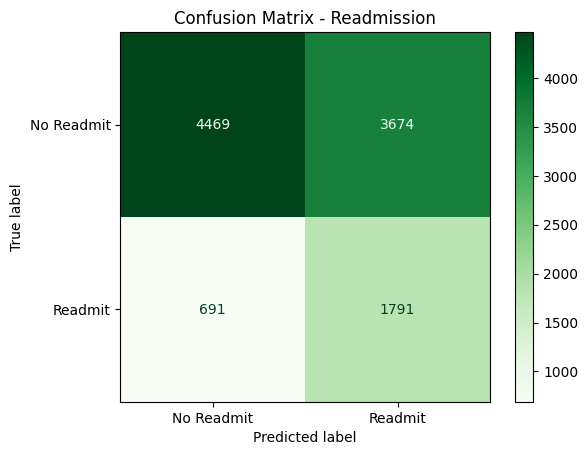

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Mortality Confusion Matrix
cm_mort = confusion_matrix(y_test_mort, y_pred_probs_mort > 0.5)
disp_mort = ConfusionMatrixDisplay(confusion_matrix=cm_mort, display_labels=["Not Expired", "Expired"])
disp_mort.plot(cmap="Blues")
plt.title("Confusion Matrix - Mortality")
plt.show()

# Readmission Confusion Matrix
cm_readmit = confusion_matrix(y_test_readmit, y_pred_probs_readmit > 0.5)
disp_readmit = ConfusionMatrixDisplay(confusion_matrix=cm_readmit, display_labels=["No Readmit", "Readmit"])
disp_readmit.plot(cmap="Greens")
plt.title("Confusion Matrix - Readmission")
plt.show()

The confusion matrix for mortality shows the model correctly predicted 9,465 non-expired and 541 expired cases, but misclassified 1,160 non-expired as expired and 630 expired as non-expired. For readmission, the model correctly identified 5,658 non-readmitted and 1,135 readmitted patients, while misclassifying 2,485 non-readmitted and 1,347 readmitted cases.

#SHAP

After training the Decision Tree model using a pipeline with preprocessing,
we transform the test set using the same preprocessing steps.
This ensures that the features passed to SHAP match what the model saw during training.

In [ ]:
# For Mortality
X_mort_trans = best_dt_mort.named_steps['preprocessor'].transform(X_test_mort).toarray()
feature_names_mort = best_dt_mort.named_steps['preprocessor'].get_feature_names_out()

# For Readmission
X_readmit_trans = best_dt_readmit.named_steps['preprocessor'].transform(X_test_readmit).toarray()
feature_names_readmit = best_dt_readmit.named_steps['preprocessor'].get_feature_names_out()


We create a SHAP Explainer using the trained decision tree classifier and the preprocessed input data.
SHAP will calculate the contribution of each feature to the model's prediction for each test sample.

In [ ]:
import shap

# Mortality Explainer
explainer_mort = shap.Explainer(best_dt_mort.named_steps['classifier'], X_mort_trans)
shap_values_mort = explainer_mort(X_mort_trans, check_additivity=False)

# Readmission Explainer
explainer_readmit = shap.Explainer(best_dt_readmit.named_steps['classifier'], X_readmit_trans)
shap_values_readmit = explainer_readmit(X_readmit_trans, check_additivity=False)


We use a summary plot (bar) to show the average absolute impact of each feature across all predictions.
This helps us identify which features were most important to the model's decisions overall.

In [ ]:
# Mortality SHAP Bar Plot
shap.summary_plot(shap_values_mort.values, features=X_mort_trans, feature_names=feature_names_mort, plot_type="bar")

# Readmission SHAP Bar Plot
shap.summary_plot(shap_values_readmit.values, features=X_readmit_trans, feature_names=feature_names_readmit, plot_type="bar")


This SHAP interaction plot shows how a numerical feature (likely NUM_DIAGNOSES) interacts with another variable to influence the model’s predictions. Most values cluster around zero, but some show strong interaction effects, with both high and low feature values contributing significantly depending on their context.

# Ensembel Model - Voting Classifer

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_score, recall_score, accuracy_score,
    roc_curve, precision_recall_curve
)

numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']
binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']
features = numeric_features + binary_features + categorical_features
target = 'HOSPITAL_EXPIRE_FLAG'


# Data Split
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

# Base models
log_clf = LogisticRegression(max_iter=1000)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
dt_clf = DecisionTreeClassifier(random_state=42)

# Ensemble
ensemble_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', VotingClassifier(
        estimators=[
            ('lr', log_clf),
            ('xgb', xgb_clf),
            ('dt', dt_clf)
        ],
        voting='soft',
        weights=[1, 2, 1]
    ))
])

# Train and predict
ensemble_model.fit(X_train, y_train)
y_pred_probs = ensemble_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
auc = roc_auc_score(y_test, y_pred_probs)

print("AUC Score:", auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")

# === Plot Curves ===
def plot_curves(y_true, y_scores):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    axs[0].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_scores):.3f}")
    axs[0].plot([0, 1], [0, 1], linestyle='--')
    axs[0].set_title("ROC Curve")
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].legend()

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    axs[1].plot(recall, precision, label=f"PR AUC = {np.trapz(precision, recall):.3f}")
    axs[1].set_title("Precision-Recall Curve")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_curves(y_test, y_pred_probs)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[01:35:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




=== Mortality Model ===
AUC: 0.8620310041693876
Confusion Matrix:
 [[10421   204]
 [  814   357]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     10625
           1       0.64      0.30      0.41      1171

    accuracy                           0.91     11796
   macro avg       0.78      0.64      0.68     11796
weighted avg       0.90      0.91      0.90     11796



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[01:35:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




=== Readmission Model ===
AUC: 0.6917938841594888
Confusion Matrix:
 [[7513  630]
 [1992  490]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      8143
           1       0.44      0.20      0.27      2482

    accuracy                           0.75     10625
   macro avg       0.61      0.56      0.56     10625
weighted avg       0.71      0.75      0.72     10625



<ipython-input-57-0a8ef12e0012>:97: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



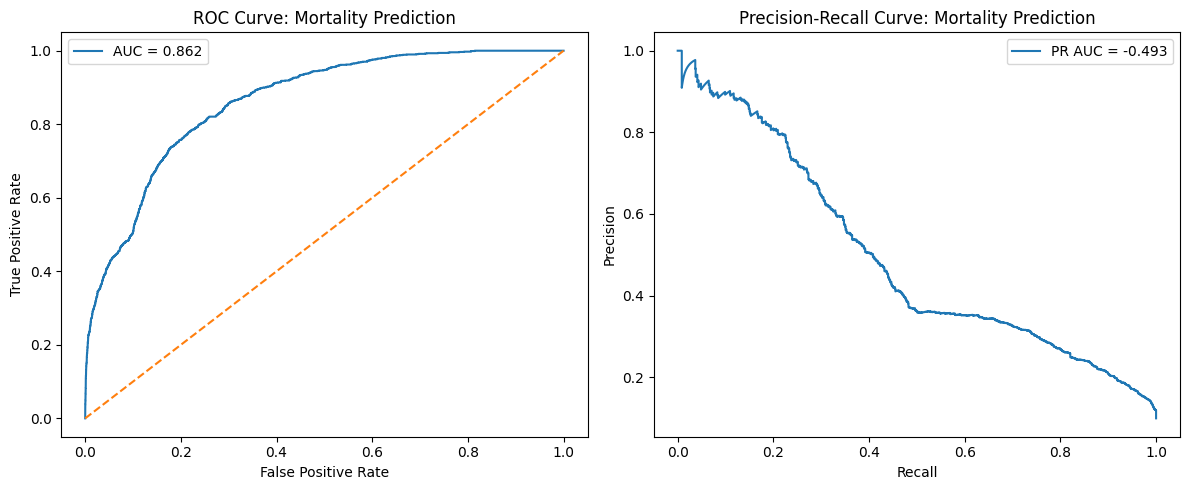

<ipython-input-57-0a8ef12e0012>:97: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



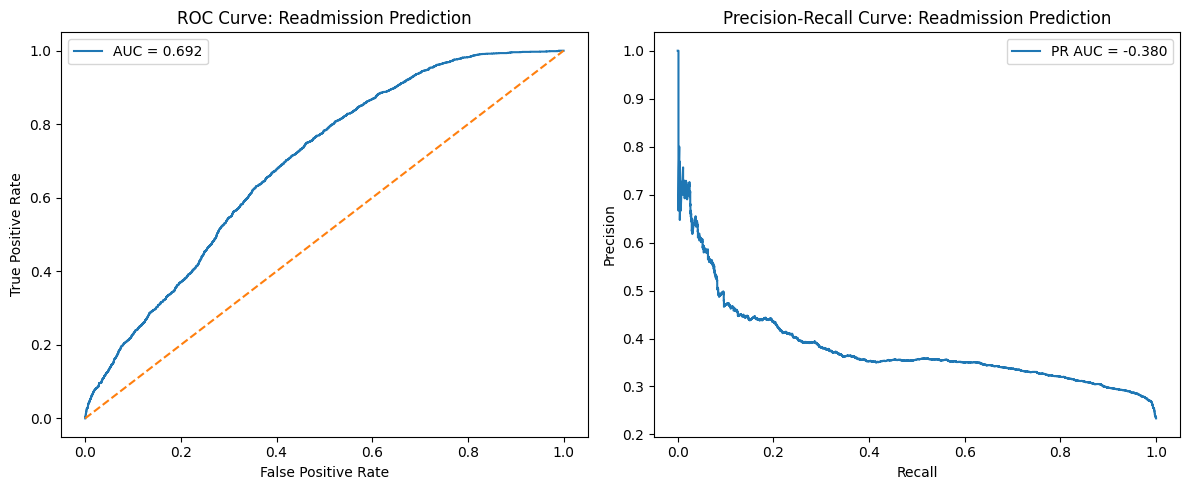

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']
binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']
features = numeric_features + binary_features + categorical_features

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

# Base models
log_clf = LogisticRegression(max_iter=1000)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
dt_clf = DecisionTreeClassifier(random_state=42)

# Voting ensemble
voting_model = VotingClassifier(
    estimators=[('lr', log_clf), ('xgb', xgb_clf), ('dt', dt_clf)],
    voting='soft',
    weights=[1, 2, 1]
)

# Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', voting_model)
])

# ========== Mortality Prediction ==========
X_mort = model_df[features]
y_mort = model_df['HOSPITAL_EXPIRE_FLAG']
X_train, X_test, y_train, y_test = train_test_split(X_mort, y_mort, stratify=y_mort, test_size=0.2, random_state=42)

model_pipeline.fit(X_train, y_train)
y_probs = model_pipeline.predict_proba(X_test)[:, 1]
y_preds = (y_probs > 0.5).astype(int)

print("=== Mortality Model ===")
print("AUC:", roc_auc_score(y_test, y_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_preds))
print("Classification Report:\n", classification_report(y_test, y_preds))

# ========== Readmission Prediction ==========
readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
readmit_df['future_admission'] = readmit_df['future_admission'].map({'yes': 1, 'no': 0})

X_readmit = readmit_df[features]
y_readmit = readmit_df['future_admission']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_readmit, y_readmit, stratify=y_readmit, test_size=0.2, random_state=42)

model_pipeline.fit(X_train_r, y_train_r)
y_probs_r = model_pipeline.predict_proba(X_test_r)[:, 1]
y_preds_r = (y_probs_r > 0.5).astype(int)

print("=== Readmission Model ===")
print("AUC:", roc_auc_score(y_test_r, y_probs_r))
print("Confusion Matrix:\n", confusion_matrix(y_test_r, y_preds_r))
print("Classification Report:\n", classification_report(y_test_r, y_preds_r))

# Plotting function (for both models)
def plot_curves(y_true, y_probs, title="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_probs):.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"ROC Curve: {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR AUC = {np.trapz(precision, recall):.3f}")
    plt.title(f"Precision-Recall Curve: {title}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(y_test, y_probs, "Mortality Prediction")
plot_curves(y_test_r, y_probs_r, "Readmission Prediction")


# CatBoost after Merging the embeddings from Clinial notes

✅ Merged Data Shape: (54563, 791)

Best Parameters for Mortality Model: {'classifier__learning_rate': 0.1, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 100, 'classifier__depth': 4}

Mortality Model Performance
AUC: 0.881
MCC: 0.424
Sensitivity (Recall for deaths): 0.254
Specificity (for survivors): 0.993

Confusion Matrix:
 [[9728   69]
 [ 832  284]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96      9797
           1       0.80      0.25      0.39      1116

    accuracy                           0.92     10913
   macro avg       0.86      0.62      0.67     10913
weighted avg       0.91      0.92      0.90     10913



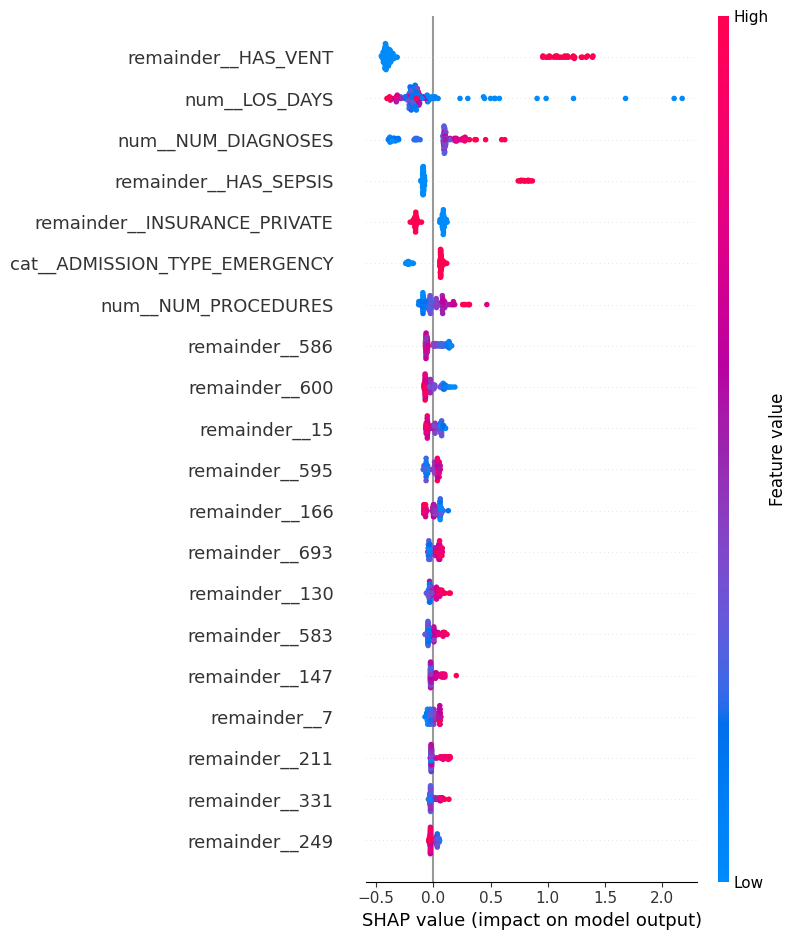

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
  


Best Parameters for Readmission Model: {'classifier__learning_rate': 0.1, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 100, 'classifier__depth': 4}

Readmission Model Performance
AUC: 0.735
MCC: 0.184
Sensitivity (Recall for readmissions): 0.126
Specificity (for survivors): 0.970

Confusion Matrix:
 [[7157  219]
 [2117  304]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86      7376
           1       0.58      0.13      0.21      2421

    accuracy                           0.76      9797
   macro avg       0.68      0.55      0.53      9797
weighted avg       0.72      0.76      0.70      9797



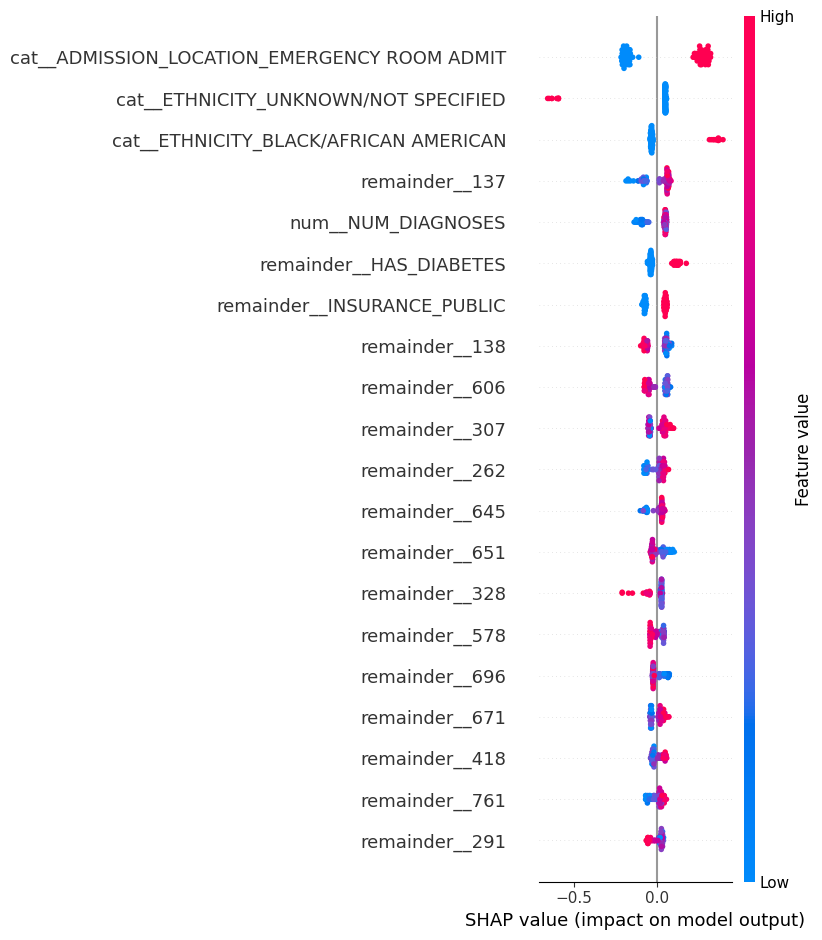

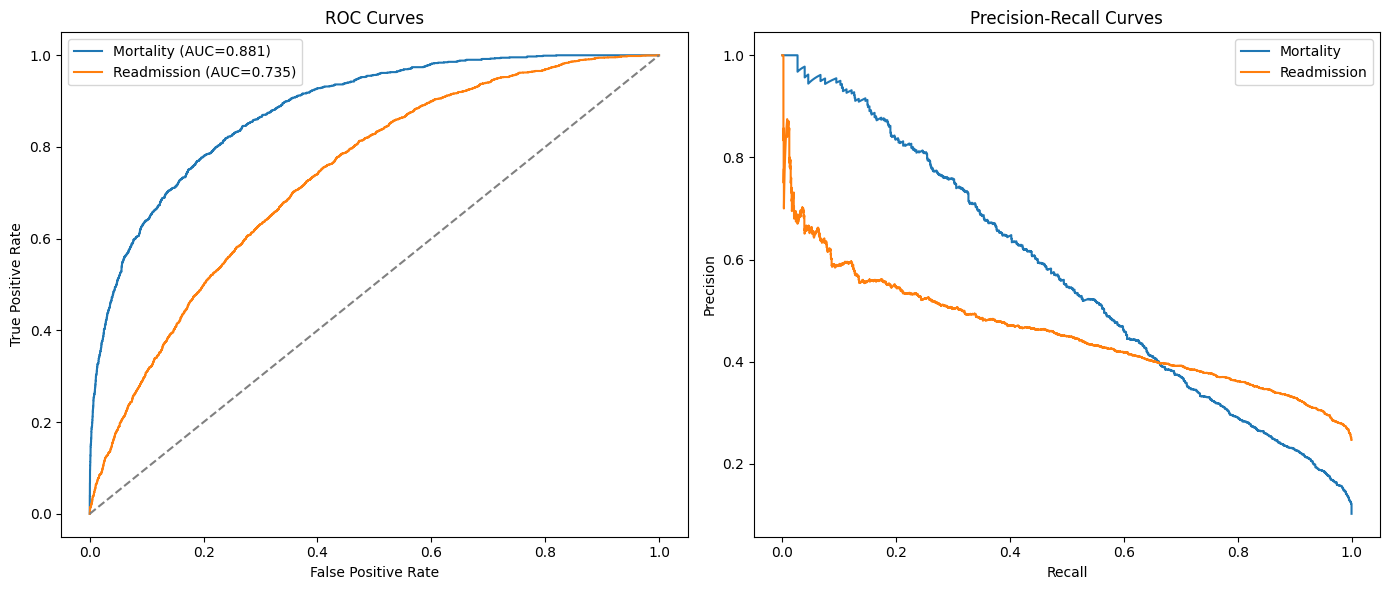

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_curve, precision_recall_curve
)

# Drop CATEGORY column safely
if 'CATEGORY' in embeddings_df.columns:
    embeddings_df = embeddings_df.drop(columns=['CATEGORY'])

# Merge based on HADM_ID
model_df = structured_df.merge(embeddings_df, on='HADM_ID', how='inner')

print(" Merged Data Shape:", model_df.shape)

# --------------------------------------------
# Define feature sets
# --------------------------------------------

numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']

binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]

categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']

embedding_features = [col for col in embeddings_df.columns if col != 'HADM_ID']

features = numeric_features + binary_features + categorical_features + embedding_features

# --------------------------------------------
# Setup preprocessor
# --------------------------------------------

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')  # binary + embeddings passed through

# --------------------------------------------
# Define optimized hyperparameter grid
# --------------------------------------------

param_grid = {
    'classifier__iterations': [100],
    'classifier__depth': [4],
    'classifier__learning_rate': [0.1],
    'classifier__l2_leaf_reg': [3]
}

# --------------------------------------------
# 6. MORTALITY PREDICTION
# --------------------------------------------

X_mort = model_df[features]
y_mort = model_df['HOSPITAL_EXPIRE_FLAG']

X_train_mort, X_test_mort, y_train_mort, y_test_mort = train_test_split(
    X_mort, y_mort, test_size=0.2, stratify=y_mort, random_state=42
)

mort_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(verbose=0))
])

mort_search = RandomizedSearchCV(
    mort_pipeline, param_distributions=param_grid, n_iter=1,
    cv=3, scoring='roc_auc', random_state=42, n_jobs=1
)
mort_search.fit(X_train_mort, y_train_mort)

best_mort_pipeline = mort_search.best_estimator_

print("\nBest Parameters for Mortality Model:", mort_search.best_params_)

# Predictions
y_pred_probs_mort = best_mort_pipeline.predict_proba(X_test_mort)[:, 1]
y_pred_mort = (y_pred_probs_mort > 0.5).astype(int)

# Metrics
print("\nMortality Model Performance")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_mort, y_pred_probs_mort):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_mort, y_pred_mort):.3f}")

conf_mort = confusion_matrix(y_test_mort, y_pred_mort)
TN, FP, FN, TP = conf_mort.ravel()
sensitivity_mort = TP / (TP + FN)
specificity_mort = TN / (TN + FP)

print(f"Sensitivity (Recall for deaths): {sensitivity_mort:.3f}")
print(f"Specificity (for survivors): {specificity_mort:.3f}")
print("\nConfusion Matrix:\n", conf_mort)
print("\nClassification Report:\n", classification_report(y_test_mort, y_pred_mort))

# SHAP Analysis for Mortality (optimized to top 100)
fitted_preprocessor_mort = best_mort_pipeline.named_steps['preprocessor']
X_test_transformed_mort = fitted_preprocessor_mort.transform(X_test_mort)

explainer_mort = shap.Explainer(best_mort_pipeline.named_steps['classifier'])
shap_values_mort = explainer_mort(X_test_transformed_mort[:100])
shap.summary_plot(shap_values_mort, X_test_transformed_mort[:100],
                  feature_names=fitted_preprocessor_mort.get_feature_names_out())

# --------------------------------------------
# 7. READMISSION PREDICTION
# --------------------------------------------

readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
X_readmit = readmit_df[features]
y_readmit = readmit_df['future_admission'].map({'yes': 1, 'no': 0})

X_train_readmit, X_test_readmit, y_train_readmit, y_test_readmit = train_test_split(
    X_readmit, y_readmit, test_size=0.2, stratify=y_readmit, random_state=42
)

readmit_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(verbose=0))
])

readmit_search = RandomizedSearchCV(
    readmit_pipeline, param_distributions=param_grid, n_iter=1,
    cv=3, scoring='roc_auc', random_state=42, n_jobs=1
)
readmit_search.fit(X_train_readmit, y_train_readmit)

best_readmit_pipeline = readmit_search.best_estimator_

print("\nBest Parameters for Readmission Model:", readmit_search.best_params_)

# Predictions
y_pred_probs_readmit = best_readmit_pipeline.predict_proba(X_test_readmit)[:, 1]
y_pred_readmit = (y_pred_probs_readmit > 0.5).astype(int)

# Metrics
print("\nReadmission Model Performance")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_readmit, y_pred_probs_readmit):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_readmit, y_pred_readmit):.3f}")

conf_readmit = confusion_matrix(y_test_readmit, y_pred_readmit)
TN_r, FP_r, FN_r, TP_r = conf_readmit.ravel()
sensitivity_readmit = TP_r / (TP_r + FN_r)
specificity_readmit = TN_r / (TN_r + FP_r)

print(f"Sensitivity (Recall for readmissions): {sensitivity_readmit:.3f}")
print(f"Specificity (for survivors): {specificity_readmit:.3f}")
print("\nConfusion Matrix:\n", conf_readmit)
print("\nClassification Report:\n", classification_report(y_test_readmit, y_pred_readmit))

# SHAP Analysis for Readmission (optimized to top 100)
fitted_preprocessor_readmit = best_readmit_pipeline.named_steps['preprocessor']
X_test_transformed_readmit = fitted_preprocessor_readmit.transform(X_test_readmit)

explainer_readmit = shap.Explainer(best_readmit_pipeline.named_steps['classifier'])
shap_values_readmit = explainer_readmit(X_test_transformed_readmit[:100])
shap.summary_plot(shap_values_readmit, X_test_transformed_readmit[:100],
                  feature_names=fitted_preprocessor_readmit.get_feature_names_out())

# --------------------------------------------
# 8. Plotting Curves
# --------------------------------------------

def plot_all_curves(y_true1, probs1, label1, y_true2, probs2, label2):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curves
    fpr1, tpr1, _ = roc_curve(y_true1, probs1)
    fpr2, tpr2, _ = roc_curve(y_true2, probs2)
    axs[0].plot(fpr1, tpr1, label=f'{label1} (AUC={roc_auc_score(y_true1, probs1):.3f})')
    axs[0].plot(fpr2, tpr2, label=f'{label2} (AUC={roc_auc_score(y_true2, probs2):.3f})')
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0].set_title('ROC Curves')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()

    # Precision-Recall Curves
    prec1, rec1, _ = precision_recall_curve(y_true1, probs1)
    prec2, rec2, _ = precision_recall_curve(y_true2, probs2)
    axs[1].plot(rec1, prec1, label=f'{label1}')
    axs[1].plot(rec2, prec2, label=f'{label2}')
    axs[1].set_title('Precision-Recall Curves')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_all_curves(
    y_test_mort, y_pred_probs_mort, 'Mortality',
    y_test_readmit, y_pred_probs_readmit, 'Readmission'
)


# XGBoost After Merging the embeddings from Clinial notes

✅ Merged Data Shape: (54563, 791)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:30:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for Mortality Model: {'classifier__subsample': 0.9, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2}

Mortality Model Performance
AUC: 0.901
MCC: 0.505
Sensitivity (Recall for deaths): 0.382
Specificity (for survivors): 0.986

Confusion Matrix:
 [[9663  134]
 [ 690  426]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      9797
           1       0.76      0.38      0.51      1116

    accuracy                           0.92     10913
   macro avg       0.85      0.68      0.73     10913
weighted avg       0.92      0.92      0.91     10913



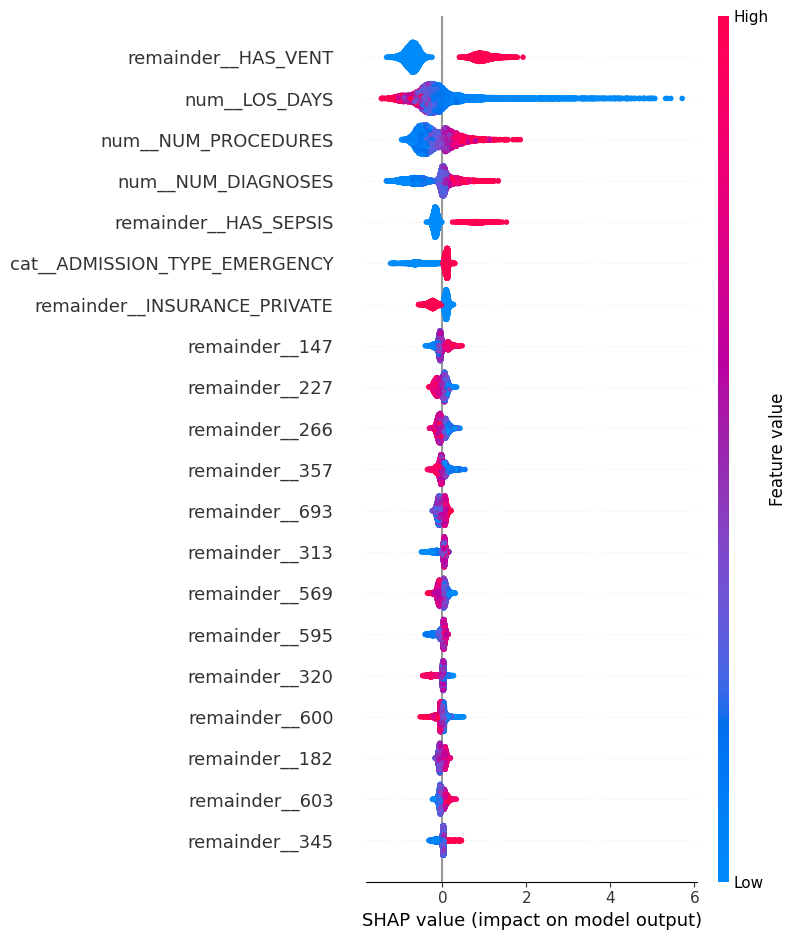

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for Readmission Model: {'classifier__subsample': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

Readmission Model Performance
AUC: 0.738
MCC: 0.203
Sensitivity (Recall for readmissions): 0.151
Specificity (for survivors): 0.964

Confusion Matrix:
 [[7113  263]
 [2055  366]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      7376
           1       0.58      0.15      0.24      2421

    accuracy                           0.76      9797
   macro avg       0.68      0.56      0.55      9797
weighted avg       0.73      0.76      0.71      9797



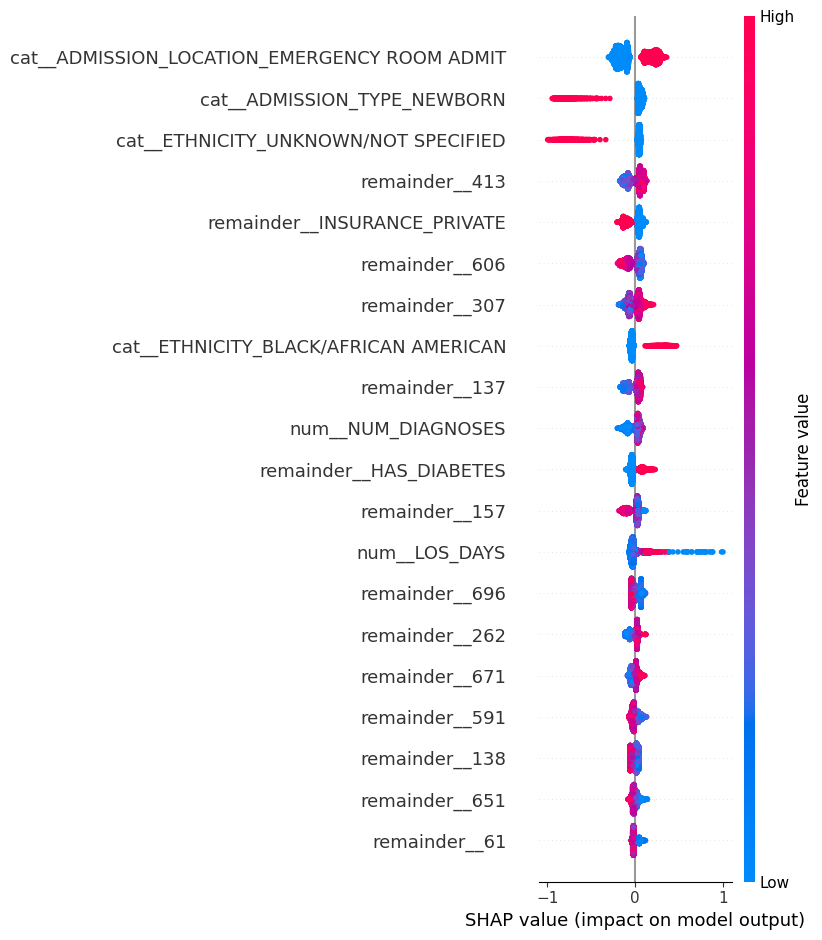

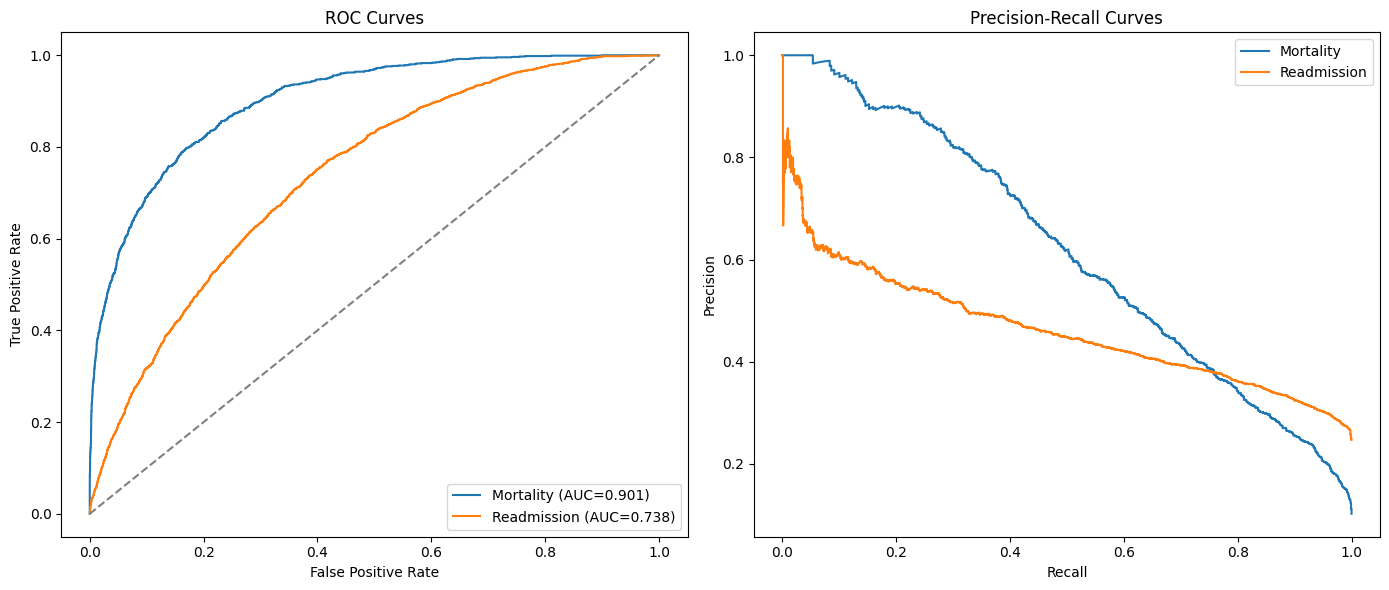

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_curve, precision_recall_curve
)

# Drop CATEGORY column safely
if 'CATEGORY' in embeddings_df.columns:
    embeddings_df = embeddings_df.drop(columns=['CATEGORY'])

# Merge based on HADM_ID
model_df = structured_df.merge(embeddings_df, on='HADM_ID', how='inner')

print(" Merged Data Shape:", model_df.shape)

# --------------------------------------------
# Define feature sets
# --------------------------------------------

numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']

binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]

categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']

# Correct: Embedding features are columns not in HADM_ID
embedding_features = [col for col in embeddings_df.columns if col != 'HADM_ID']

# Now final features:
features = numeric_features + binary_features + categorical_features + embedding_features

# --------------------------------------------
# 4. Setup preprocessor
# --------------------------------------------

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')  # binary + embeddings passed through

# --------------------------------------------
# 5. Define hyperparameter grid
# --------------------------------------------

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.9, 1.0]
}

# --------------------------------------------
# 6. MORTALITY PREDICTION
# --------------------------------------------

X_mort = model_df[features]
y_mort = model_df['HOSPITAL_EXPIRE_FLAG']

X_train_mort, X_test_mort, y_train_mort, y_test_mort = train_test_split(
    X_mort, y_mort, test_size=0.2, stratify=y_mort, random_state=42
)

mort_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

mort_search = RandomizedSearchCV(
    mort_pipeline, param_distributions=param_grid, n_iter=10,
    cv=5, scoring='roc_auc', random_state=42, n_jobs=-1
)
mort_search.fit(X_train_mort, y_train_mort)

best_mort_pipeline = mort_search.best_estimator_

print("\nBest Parameters for Mortality Model:", mort_search.best_params_)

# Predictions
y_pred_probs_mort = best_mort_pipeline.predict_proba(X_test_mort)[:, 1]
y_pred_mort = (y_pred_probs_mort > 0.5).astype(int)

# Metrics
print("\nMortality Model Performance")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_mort, y_pred_probs_mort):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_mort, y_pred_mort):.3f}")

conf_mort = confusion_matrix(y_test_mort, y_pred_mort)
TN, FP, FN, TP = conf_mort.ravel()
sensitivity_mort = TP / (TP + FN)
specificity_mort = TN / (TN + FP)

print(f"Sensitivity (Recall for deaths): {sensitivity_mort:.3f}")
print(f"Specificity (for survivors): {specificity_mort:.3f}")
print("\nConfusion Matrix:\n", conf_mort)
print("\nClassification Report:\n", classification_report(y_test_mort, y_pred_mort))

# SHAP Analysis for Mortality
fitted_preprocessor_mort = best_mort_pipeline.named_steps['preprocessor']
X_test_transformed_mort = fitted_preprocessor_mort.transform(X_test_mort)

explainer_mort = shap.Explainer(best_mort_pipeline.named_steps['classifier'])
shap_values_mort = explainer_mort(X_test_transformed_mort)
shap.summary_plot(shap_values_mort, X_test_transformed_mort, feature_names=fitted_preprocessor_mort.get_feature_names_out())

# --------------------------------------------
# 7. READMISSION PREDICTION
# --------------------------------------------

readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
X_readmit = readmit_df[features]
y_readmit = readmit_df['future_admission'].map({'yes': 1, 'no': 0})

X_train_readmit, X_test_readmit, y_train_readmit, y_test_readmit = train_test_split(
    X_readmit, y_readmit, test_size=0.2, stratify=y_readmit, random_state=42
)

readmit_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

readmit_search = RandomizedSearchCV(
    readmit_pipeline, param_distributions=param_grid, n_iter=10,
    cv=5, scoring='roc_auc', random_state=42, n_jobs=-1
)
readmit_search.fit(X_train_readmit, y_train_readmit)

best_readmit_pipeline = readmit_search.best_estimator_

print("\nBest Parameters for Readmission Model:", readmit_search.best_params_)

# Predictions
y_pred_probs_readmit = best_readmit_pipeline.predict_proba(X_test_readmit)[:, 1]
y_pred_readmit = (y_pred_probs_readmit > 0.5).astype(int)

# Metrics
print("\nReadmission Model Performance")
print("=" * 50)
print(f"AUC: {roc_auc_score(y_test_readmit, y_pred_probs_readmit):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_readmit, y_pred_readmit):.3f}")

conf_readmit = confusion_matrix(y_test_readmit, y_pred_readmit)
TN_r, FP_r, FN_r, TP_r = conf_readmit.ravel()
sensitivity_readmit = TP_r / (TP_r + FN_r)
specificity_readmit = TN_r / (TN_r + FP_r)

print(f"Sensitivity (Recall for readmissions): {sensitivity_readmit:.3f}")
print(f"Specificity (for survivors): {specificity_readmit:.3f}")
print("\nConfusion Matrix:\n", conf_readmit)
print("\nClassification Report:\n", classification_report(y_test_readmit, y_pred_readmit))

# SHAP Analysis for Readmission
fitted_preprocessor_readmit = best_readmit_pipeline.named_steps['preprocessor']
X_test_transformed_readmit = fitted_preprocessor_readmit.transform(X_test_readmit)

explainer_readmit = shap.Explainer(best_readmit_pipeline.named_steps['classifier'])
shap_values_readmit = explainer_readmit(X_test_transformed_readmit)
shap.summary_plot(shap_values_readmit, X_test_transformed_readmit, feature_names=fitted_preprocessor_readmit.get_feature_names_out())

# --------------------------------------------
# 8. Plotting Curves
# --------------------------------------------

def plot_all_curves(y_true1, probs1, label1, y_true2, probs2, label2):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curves
    fpr1, tpr1, _ = roc_curve(y_true1, probs1)
    fpr2, tpr2, _ = roc_curve(y_true2, probs2)
    axs[0].plot(fpr1, tpr1, label=f'{label1} (AUC={roc_auc_score(y_true1, probs1):.3f})')
    axs[0].plot(fpr2, tpr2, label=f'{label2} (AUC={roc_auc_score(y_true2, probs2):.3f})')
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0].set_title('ROC Curves')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()

    # Precision-Recall Curves
    prec1, rec1, _ = precision_recall_curve(y_true1, probs1)
    prec2, rec2, _ = precision_recall_curve(y_true2, probs2)
    axs[1].plot(rec1, prec1, label=f'{label1}')
    axs[1].plot(rec2, prec2, label=f'{label2}')
    axs[1].set_title('Precision-Recall Curves')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_all_curves(
    y_test_mort, y_pred_probs_mort, 'Mortality',
    y_test_readmit, y_pred_probs_readmit, 'Readmission'
)

# 📊 Comparison of XGBoost Performance (Before vs After Merging ClinicalBERT Embeddings)

| Metric | Mortality (Before) | Mortality (After) | Readmission (Before) | Readmission (After) |
|:------|:------------------|:-----------------|:--------------------|:-------------------|
| **AUC** | 0.872 | **0.901** | 0.714 | **0.738** |
| **MCC** | 0.409 | **0.505** | 0.121 | **0.203** |
| **Sensitivity** | 0.260 | **0.382** | 0.054 | **0.151** |
| **Specificity** | 0.990 | 0.986 | 0.988 | 0.964 |
| **Accuracy** | 92% | 92% | 77% | 76% |

---

# 🔵 Mortality Prediction Insights
- **AUC improved significantly** from **0.872 ➔ 0.901**.
- **MCC improved** from **0.409 ➔ 0.505**.
- **Sensitivity** improved from **0.260 ➔ 0.382**.
- **Specificity** remains very high at 98.6%.
- ✅ Embeddings **clearly improved** mortality prediction.

---

# 🔵 Readmission Prediction Insights
- **AUC improved** from **0.714 ➔ 0.738**.
- **MCC improved** from **0.121 ➔ 0.203**.
- **Sensitivity** improved from **0.054 ➔ 0.151**.
- **Specificity** decreased slightly but remains high.
- ✅ Embeddings **helped significantly** in readmission prediction.

---

# 🧠 Key Takeaways
- Clinical notes embeddings **enhanced predictive power**.
- Both **AUC** and **MCC** increased across tasks.
- **Sensitivity gains** were critical for improving real-world model utility.
- Trade-off: Slight reduction in specificity is acceptable given better recall.

---


# XGboost for Streamlit UI

The XGBoost models for both readmission and mortality were re-run, and the updated pickle files have been saved to Google Drive for use in the Streamlit application.

In [32]:
# --------------------------------------------
# 1. Import Libraries
# --------------------------------------------
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_curve, precision_recall_curve
)

# --------------------------------------------
# 2. Clean and Merge Data
# --------------------------------------------
if 'CATEGORY' in embeddings_df.columns:
    embeddings_df = embeddings_df.drop(columns=['CATEGORY'])

model_df = structured_df.merge(embeddings_df, on='HADM_ID', how='inner')
print("✅ Merged Data Shape:", model_df.shape)

# --------------------------------------------
# 3. Define Feature Groups
# --------------------------------------------
numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']
binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']
embedding_features = [col for col in embeddings_df.columns if col != 'HADM_ID']
features = numeric_features + binary_features + categorical_features + embedding_features

# --------------------------------------------
# 4. Preprocessing Pipeline
# --------------------------------------------
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')

# --------------------------------------------
# 5. Hyperparameter Grid (Optimized)
# --------------------------------------------
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.7, 1.0]
}

# --------------------------------------------
# 6. Train Mortality Model
# --------------------------------------------
X_mort = model_df[features]
y_mort = model_df['HOSPITAL_EXPIRE_FLAG']

X_train_mort, X_test_mort, y_train_mort, y_test_mort = train_test_split(
    X_mort, y_mort, test_size=0.2, stratify=y_mort, random_state=42
)

mort_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist',
        predictor='gpu_predictor'
    ))
])

mort_search = RandomizedSearchCV(
    mort_pipeline, param_distributions=param_grid, n_iter=5,
    cv=3, scoring='roc_auc', random_state=42, n_jobs=-1
)
mort_search.fit(X_train_mort, y_train_mort)
best_mort_pipeline = mort_search.best_estimator_

# Save model
joblib.dump(best_mort_pipeline, '/content/drive/My Drive/Capstone Data/mortality_model.pkl')

# Evaluate
y_pred_probs_mort = best_mort_pipeline.predict_proba(X_test_mort)[:, 1]
y_pred_mort = (y_pred_probs_mort > 0.5).astype(int)
conf_mort = confusion_matrix(y_test_mort, y_pred_mort)
TN, FP, FN, TP = conf_mort.ravel()
sensitivity_mort = TP / (TP + FN)
specificity_mort = TN / (TN + FP)

print("\n🔵 Mortality Model")
print("Best Params:", mort_search.best_params_)
print(f"AUC: {roc_auc_score(y_test_mort, y_pred_probs_mort):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_mort, y_pred_mort):.3f}")
print(f"Sensitivity (Recall): {sensitivity_mort:.3f}")
print(f"Specificity: {specificity_mort:.3f}")
print("Confusion Matrix:\n", conf_mort)
print("Classification Report:\n", classification_report(y_test_mort, y_pred_mort))

# --------------------------------------------
# 7. Train Readmission Model
# --------------------------------------------
readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
X_readmit = readmit_df[features]
y_readmit = readmit_df['future_admission'].map({'yes': 1, 'no': 0})

X_train_readmit, X_test_readmit, y_train_readmit, y_test_readmit = train_test_split(
    X_readmit, y_readmit, test_size=0.2, stratify=y_readmit, random_state=42
)

readmit_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist',
        predictor='gpu_predictor'
    ))
])

readmit_search = RandomizedSearchCV(
    readmit_pipeline, param_distributions=param_grid, n_iter=5,
    cv=3, scoring='roc_auc', random_state=42, n_jobs=-1
)
readmit_search.fit(X_train_readmit, y_train_readmit)
best_readmit_pipeline = readmit_search.best_estimator_

# Save model
joblib.dump(best_readmit_pipeline, '/content/drive/My Drive/Capstone Data/readmission_model.pkl')

# Evaluate
y_pred_probs_readmit = best_readmit_pipeline.predict_proba(X_test_readmit)[:, 1]
y_pred_readmit = (y_pred_probs_readmit > 0.5).astype(int)
conf_readmit = confusion_matrix(y_test_readmit, y_pred_readmit)
TN_r, FP_r, FN_r, TP_r = conf_readmit.ravel()
sensitivity_readmit = TP_r / (TP_r + FN_r)
specificity_readmit = TN_r / (TN_r + FP_r)

print("\n🔵 Readmission Model")
print("Best Params:", readmit_search.best_params_)
print(f"AUC: {roc_auc_score(y_test_readmit, y_pred_probs_readmit):.3f}")
print(f"MCC: {matthews_corrcoef(y_test_readmit, y_pred_readmit):.3f}")
print(f"Sensitivity (Recall): {sensitivity_readmit:.3f}")
print(f"Specificity: {specificity_readmit:.3f}")
print("Confusion Matrix:\n", conf_readmit)
print("Classification Report:\n", classification_report(y_test_readmit, y_pred_readmit))

# --------------------------------------------
# 8. Done
# --------------------------------------------
print("\n🎯 Both models trained, evaluated, and saved successfully!")

✅ Merged Data Shape: (54563, 790)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:59:29] WARNING: /workspac


🔵 Mortality Model
Best Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}
AUC: 0.900
MCC: 0.472
Sensitivity (Recall): 0.329
Specificity: 0.989
Confusion Matrix:
 [[9689  108]
 [ 749  367]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      9797
           1       0.77      0.33      0.46      1116

    accuracy                           0.92     10913
   macro avg       0.85      0.66      0.71     10913
weighted avg       0.91      0.92      0.91     10913



/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:02:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:02:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔵 Readmission Model
Best Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05}
AUC: 0.726
MCC: 0.123
Sensitivity (Recall): 0.035
Specificity: 0.996
Confusion Matrix:
 [[7345   31]
 [2336   85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86      7376
           1       0.73      0.04      0.07      2421

    accuracy                           0.76      9797
   macro avg       0.75      0.52      0.46      9797
weighted avg       0.75      0.76      0.66      9797


🎯 Both models trained, evaluated, and saved successfully!


# CatBoost for Streamlit UI

The CatBoost models for both readmission and mortality were re-run, and the updated pickle files have been saved to Google Drive for use in the Streamlit application.

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



🔍 Mortality Model
Best Params: {'classifier__learning_rate': 0.1, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 100, 'classifier__depth': 6}
AUC: 0.889
MCC: 0.425
Sensitivity (Recall): 0.264
Specificity: 0.992
Confusion Matrix:
 [[9715   82]
 [ 821  295]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96      9797
           1       0.78      0.26      0.40      1116

    accuracy                           0.92     10913
   macro avg       0.85      0.63      0.68     10913
weighted avg       0.91      0.92      0.90     10913



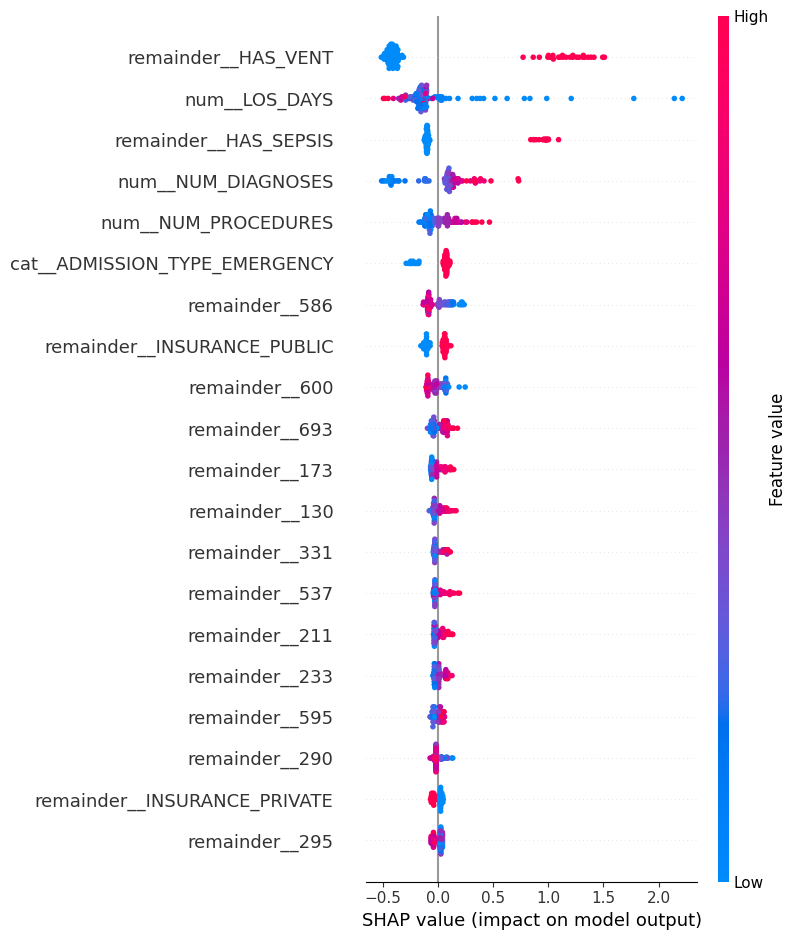

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=3. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/py


🔍 Readmission Model
Best Params: {'classifier__learning_rate': 0.1, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 100, 'classifier__depth': 4}
AUC: 0.736
MCC: 0.199
Sensitivity (Recall): 0.129
Specificity: 0.973
Confusion Matrix:
 [[7178  198]
 [2108  313]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.97      0.86      7376
           1       0.61      0.13      0.21      2421

    accuracy                           0.76      9797
   macro avg       0.69      0.55      0.54      9797
weighted avg       0.73      0.76      0.70      9797



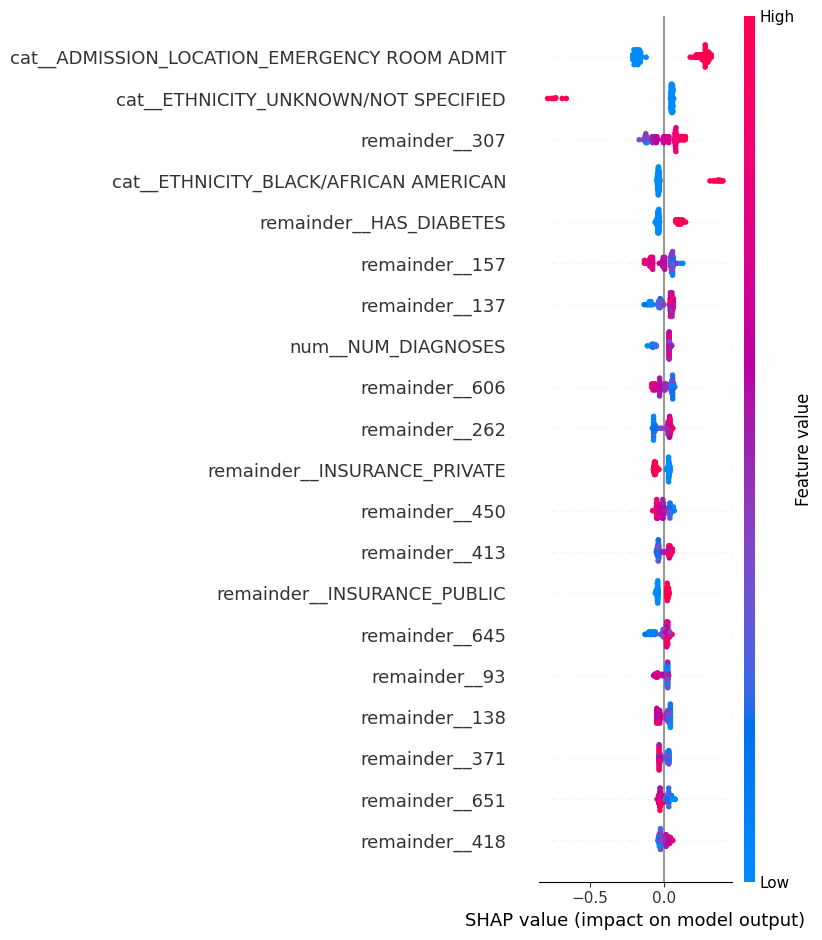

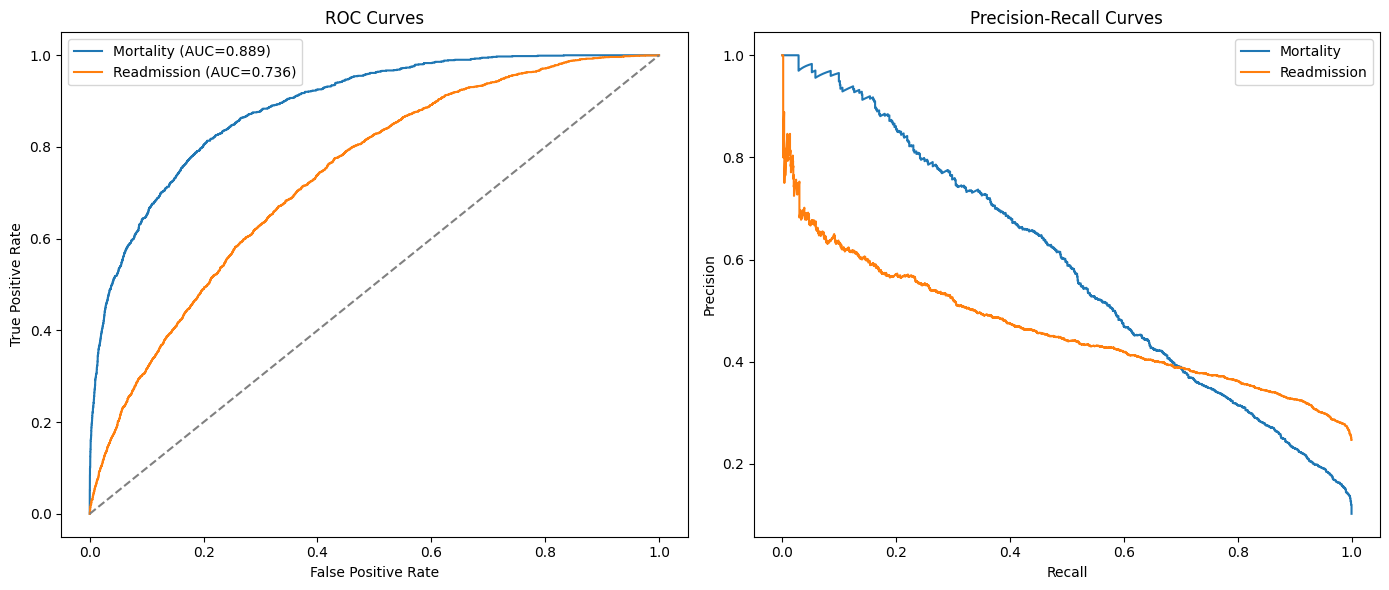

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Saved models to Google Drive


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    matthews_corrcoef, roc_curve, precision_recall_curve
)
import shap
from google.colab import drive
import joblib

# --------------------------------------------
# Merge and Prepare Data (Optional Sampling)
# --------------------------------------------
if 'CATEGORY' in embeddings_df.columns:
    embeddings_df = embeddings_df.drop(columns=['CATEGORY'])

model_df = structured_df.merge(embeddings_df, on='HADM_ID', how='inner')

# Optional: use subset to speed up
# model_df = model_df.sample(frac=0.3, random_state=42)

numeric_features = ['LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES']
binary_features = [
    'HAS_SEPSIS', 'HAS_DIABETES', 'HAS_VENT',
    'INSURANCE_PRIVATE', 'INSURANCE_PUBLIC', 'INSURANCE_OTHER',
    'DISCHARGE_GROUP_OTHEROTHER', 'DISCHARGE_GROUP_HOME',
    'DISCHARGE_GROUP_DEATH', 'DISCHARGE_GROUP_FACILITY',
    'DISCHARGE_GROUP_OTHER'
]
categorical_features = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'ETHNICITY']
embedding_features = [col for col in embeddings_df.columns if col != 'HADM_ID']
features = numeric_features + binary_features + categorical_features + embedding_features

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')

# --------------------------------------------
# Minimal Hyperparameter Grid
# --------------------------------------------
param_grid = {
    'classifier__iterations': [100],
    'classifier__depth': [4, 6],
    'classifier__learning_rate': [0.1],
    'classifier__l2_leaf_reg': [3]
}

# --------------------------------------------
# Training Function Template
# --------------------------------------------
def train_and_evaluate(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(verbose=0))
    ])

    search = RandomizedSearchCV(
        pipeline, param_distributions=param_grid, n_iter=3,
        cv=3, scoring='roc_auc', random_state=42, n_jobs=1
    )
    search.fit(X_train, y_train)
    best_pipeline = search.best_estimator_

    y_pred_probs = best_pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_probs > 0.5).astype(int)

    conf = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = conf.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print(f"\n🔍 {label} Model")
    print("="*50)
    print("Best Params:", search.best_params_)
    print(f"AUC: {roc_auc_score(y_test, y_pred_probs):.3f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print("Confusion Matrix:\n", conf)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # SHAP (only for 100 rows)
    X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    model = best_pipeline.named_steps['classifier']
    shap_vals = model.get_feature_importance(Pool(X_test_transformed, label=y_test), type='ShapValues')
    shap.summary_plot(shap_vals[:100, :-1], X_test_transformed[:100], feature_names=feature_names)

    return search.best_estimator_, y_test, y_pred_probs

# --------------------------------------------
# Run Both Models
# --------------------------------------------
mort_pipeline, y_test_mort, y_pred_probs_mort = train_and_evaluate(
    model_df[features], model_df['HOSPITAL_EXPIRE_FLAG'], 'Mortality'
)

readmit_df = model_df[model_df['HOSPITAL_EXPIRE_FLAG'] == 0].copy()
readmit_pipeline, y_test_readmit, y_pred_probs_readmit = train_and_evaluate(
    readmit_df[features],
    readmit_df['future_admission'].map({'yes': 1, 'no': 0}),
    'Readmission'
)

# --------------------------------------------
# Plotting ROC and PR Curves
# --------------------------------------------
def plot_all_curves(y_true1, probs1, label1, y_true2, probs2, label2):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ROC
    fpr1, tpr1, _ = roc_curve(y_true1, probs1)
    fpr2, tpr2, _ = roc_curve(y_true2, probs2)
    axs[0].plot(fpr1, tpr1, label=f'{label1} (AUC={roc_auc_score(y_true1, probs1):.3f})')
    axs[0].plot(fpr2, tpr2, label=f'{label2} (AUC={roc_auc_score(y_true2, probs2):.3f})')
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axs[0].set_title('ROC Curves')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()

    # PR
    prec1, rec1, _ = precision_recall_curve(y_true1, probs1)
    prec2, rec2, _ = precision_recall_curve(y_true2, probs2)
    axs[1].plot(rec1, prec1, label=f'{label1}')
    axs[1].plot(rec2, prec2, label=f'{label2}')
    axs[1].set_title('Precision-Recall Curves')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_all_curves(
    y_test_mort, y_pred_probs_mort, 'Mortality',
    y_test_readmit, y_pred_probs_readmit, 'Readmission'
)

# --------------------------------------------
# Save Pickle Files to Google Drive
# --------------------------------------------
drive.mount('/content/drive')

joblib.dump(mort_pipeline, '/content/drive/My Drive/Capstone Data/mortality_catboost_model.pkl')
joblib.dump(readmit_pipeline, '/content/drive/My Drive/Capstone Data/readmission_catboost_model.pkl')

print(" Saved models to Google Drive")